# ИССЛЕДОВАНИЕ ДАННЫХ HR-АГЕНТСТВА
HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы

Исследуйте данные и сделайте выводы по полученным результатам. Подкрепите свои рассуждения и выводы визуализациями и с помощью статистического тестирования проверьте, являются ли выводы статистически значимыми.

**В процессе своего анализа вы должны:**

1. Выяснить, какие факторы влияют на зарплату специалиста Data Scientist.
2. А также ответить на ключевые вопросы HR-агентства:
    * Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
    * Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
    * Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
    * Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

Если вы найдёте в данных интересные закономерности, также отметьте их в своём анализе.

Продемонстрируйте использование разных тестов для проверки статистической значимости сделанных выводов:
* тесты для количественного признака:
    * для одной выборки;
    * для двух выборок;
    * для нескольких выборок;
* тест для категориальных признаков.

In [1]:
import numpy as np
import pandas as pd

# import statsmodels.api as sm
# from statsmodels import stats as sms

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.descriptivestats import sign_test
from scipy import stats


%config InlineBackend.figure_format = 'retina'
%matplotlib inline

sns.set_theme('notebook') 
sns.set_palette('Set2')

plt.rcParams['figure.figsize'] = (12, 8) 

### Описание столбцов
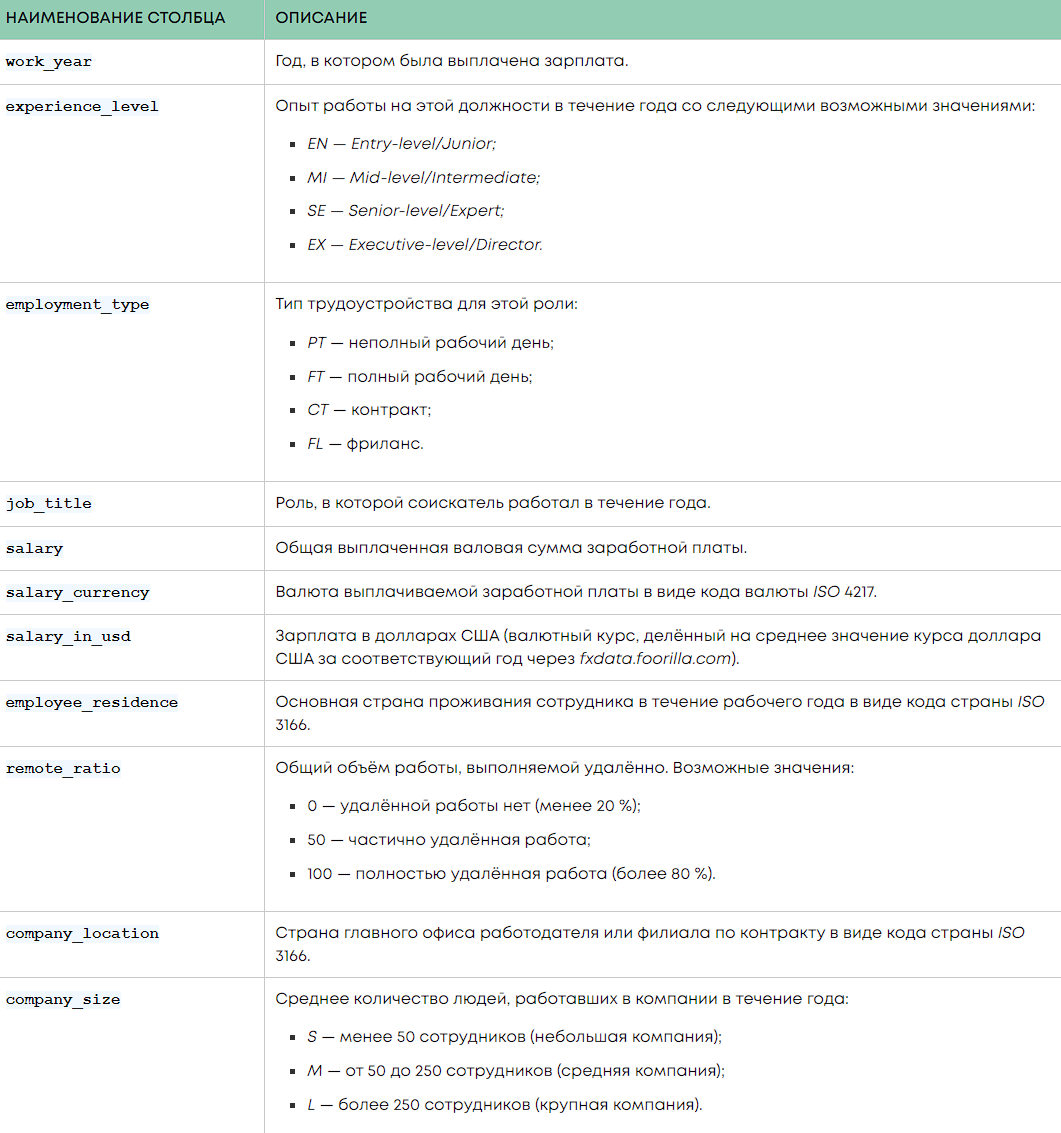

### 0. Загрузка и обработка данных

In [2]:
df = pd.read_csv('data/ds_salaries.zip', index_col=0)
df

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L
...,...,...,...,...,...,...,...,...,...,...,...
602,2022,SE,FT,Data Engineer,154000,USD,154000,US,100,US,M
603,2022,SE,FT,Data Engineer,126000,USD,126000,US,100,US,M
604,2022,SE,FT,Data Analyst,129000,USD,129000,US,0,US,M
605,2022,SE,FT,Data Analyst,150000,USD,150000,US,100,US,M


### Поиск пропусков и дубликатов

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 607 entries, 0 to 606
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           607 non-null    int64 
 1   experience_level    607 non-null    object
 2   employment_type     607 non-null    object
 3   job_title           607 non-null    object
 4   salary              607 non-null    int64 
 5   salary_currency     607 non-null    object
 6   salary_in_usd       607 non-null    int64 
 7   employee_residence  607 non-null    object
 8   remote_ratio        607 non-null    int64 
 9   company_location    607 non-null    object
 10  company_size        607 non-null    object
dtypes: int64(4), object(7)
memory usage: 56.9+ KB


явных пропусков не обнаружено

In [4]:
dublicate_mask = df.duplicated()
print(f'Обнаружено {dublicate_mask.sum()} дубликатов')

df = df.drop_duplicates().reset_index(drop=True)

Обнаружено 42 дубликатов


дубликаты удалены

### Изучаю числовые признаки

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
work_year,565.0,2021.364602,6.981384e-01,2020.0,2021.0,2021.0,2022.0,2022.0
salary,565.0,338115.985841,1.599879e+06,4000.0,67000.0,110925.0,165000.0,30400000.0
salary_in_usd,565.0,110610.343363,7.228070e+04,2859.0,60757.0,100000.0,150000.0,600000.0
remote_ratio,565.0,69.911504,4.090067e+01,0.0,50.0,100.0,100.0,100.0


In [6]:
df['remote_ratio'].value_counts()

remote_ratio
100    346
0      121
50      98
Name: count, dtype: int64

In [7]:
df['work_year'].value_counts()

work_year
2022    278
2021    215
2020     72
Name: count, dtype: int64

- remote_ratio можно считать категориальным номинальным. Всего 3 варианта и нельзя сказать что признак порядковый.
- work_year так же считаю категориальным признаком.

In [8]:
# Преобразую в категориальные признаки
df['remote_ratio'] = df['remote_ratio'].astype('category')
df['work_year'] = df['work_year'].astype('category')

Есть два признака salary, salary_in_usd. Достаточно оставить признак salary_in_usd который является приведенным к единой валюте значением salary, т.е. нормированной для всех ЗП.

In [9]:
df.drop(columns='salary', inplace=True)

### Изучаю категориальные признаки

In [10]:
df.describe(exclude='number').T

,count,unique,top,freq
work_year,565,3,2022,278
experience_level,565,4,SE,243
employment_type,565,4,FT,546
job_title,565,50,Data Scientist,130
salary_currency,565,17,USD,359
employee_residence,565,57,US,295
remote_ratio,565,3,100,346
company_location,565,50,US,318
company_size,565,3,M,290


### Изучаю частотность классов категориальных признаков с избыточным количеством классов

### job_title

In [11]:
(df['job_title'].value_counts(True) * 100).round(1).to_frame()

,proportion
job_title,
Data Scientist,23.0
Data Engineer,21.4
Data Analyst,14.5
Machine Learning Engineer,6.9
Research Scientist,2.8
Data Science Manager,2.1
Data Architect,1.9
Big Data Engineer,1.4
Machine Learning Scientist,1.4


Вижу 50 классов должностей, при этом весь объем сосредоточен в трех класса Data Scientist, Data Engineer, Data Analyst.

А с точки зрения поставленных задач нас интересует только Data Scientist, Data Engineer.

Трансформирую часть похожих специальностей в Data Scientist, Data Engineer.

И удалю все остальные из датасета.

In [12]:
df['job_title'] = df['job_title'].apply(lambda x: 'Data Scientist' if x.find('Scien') != -1 else x)
df['job_title'] = df['job_title'].apply(lambda x: 'Data Engineer' if x.find('Engi') != -1 else x)

In [13]:
df['job_title'].value_counts(True) * 100

job_title
Data Scientist                   37.876106
Data Engineer                    37.876106
Data Analyst                     14.513274
Data Architect                    1.946903
Data Analytics Manager            1.238938
BI Data Analyst                   1.061947
Business Data Analyst             0.884956
Head of Data                      0.884956
Lead Data Analyst                 0.530973
Machine Learning Developer        0.530973
Principal Data Analyst            0.353982
Financial Data Analyst            0.353982
Product Data Analyst              0.353982
Marketing Data Analyst            0.176991
3D Computer Vision Researcher     0.176991
Data Specialist                   0.176991
Machine Learning Manager          0.176991
Finance Data Analyst              0.176991
Big Data Architect                0.176991
ETL Developer                     0.176991
Head of Machine Learning          0.176991
Data Analytics Lead               0.176991
Name: proportion, dtype: float64

Получил два самых больших и сбалансированных класса которые нас интересовали. Остальные удаляю.

In [14]:
job_to_save = df['job_title'].value_counts().nlargest(2).index.to_list()
mask_for_jobs = df['job_title'].apply(lambda x: True if x in job_to_save else False)
df = df[mask_for_jobs]

In [15]:
df['job_title'].value_counts(True) * 100

job_title
Data Scientist    50.0
Data Engineer     50.0
Name: proportion, dtype: float64

### salary_currency

In [16]:
df['salary_currency'].value_counts(True) * 100

salary_currency
USD    59.345794
EUR    18.691589
GBP     8.644860
INR     4.906542
CAD     2.803738
JPY     0.700935
TRY     0.700935
PLN     0.700935
SGD     0.467290
AUD     0.467290
BRL     0.467290
DKK     0.467290
MXN     0.467290
CNY     0.467290
CLP     0.233645
HUF     0.233645
CHF     0.233645
Name: proportion, dtype: float64

Снижаю количество валют до 5, остальные объединяю в один класс

In [17]:
def decrease_category(df, col, n_cat):
    '''Функция до уменьшения числа категорий до заданного с объединением оставшихся в Other

    Args:
        df (_type_): исходный датафрейм
        col (_type_): имя признака для снижения числа категорий
        n_cat (_type_): количество ТОП категорий, которые останутся

    Returns:
        _type_: df с изменениями
    '''
    
    class_to_save = df[col].value_counts().nlargest(n_cat).index
    df[col] = df[col].apply(lambda x: x if x in class_to_save else 'Other')
    return df

In [18]:
df = decrease_category(df, 'salary_currency', 5)
df['salary_currency'].value_counts(True) * 100

salary_currency
USD      59.345794
EUR      18.691589
GBP       8.644860
Other     5.607477
INR       4.906542
CAD       2.803738
Name: proportion, dtype: float64

Итого 6 классов валют в которых платится ЗП

### employee_residence

In [19]:
df['employee_residence'].value_counts(True) * 100

employee_residence
US    48.831776
GB     8.644860
DE     5.373832
IN     5.373832
FR     3.738318
ES     2.803738
CA     2.803738
GR     1.635514
JP     1.635514
PT     1.401869
BR     1.401869
PK     1.168224
NL     1.168224
IT     0.934579
PL     0.934579
VN     0.700935
RU     0.700935
TR     0.700935
AE     0.700935
AT     0.700935
AU     0.700935
RO     0.467290
MX     0.467290
DK     0.467290
SG     0.467290
BE     0.467290
TN     0.233645
DZ     0.233645
HK     0.233645
IE     0.233645
AR     0.233645
CZ     0.233645
JE     0.233645
BO     0.233645
PR     0.233645
RS     0.233645
NZ     0.233645
SI     0.233645
MD     0.233645
CO     0.233645
IR     0.233645
CL     0.233645
MT     0.233645
UA     0.233645
NG     0.233645
HR     0.233645
HU     0.233645
PH     0.233645
CN     0.233645
CH     0.233645
Name: proportion, dtype: float64

Так же снижаю количество классов до 5, хотя US явно доминирует

In [20]:
df = decrease_category(df, 'employee_residence', 5)
df['employee_residence'].value_counts(True) * 100

employee_residence
US       48.831776
Other    28.037383
GB        8.644860
DE        5.373832
IN        5.373832
FR        3.738318
Name: proportion, dtype: float64

### company_location

In [21]:
df['company_location'].value_counts(True) * 100

company_location
US    53.271028
GB     9.345794
DE     6.074766
IN     4.205607
FR     3.037383
CA     3.037383
ES     2.570093
GR     1.401869
JP     1.401869
PL     0.934579
NL     0.934579
AT     0.934579
PT     0.934579
AU     0.700935
MX     0.700935
BR     0.700935
TR     0.700935
AE     0.700935
CH     0.467290
BE     0.467290
CZ     0.467290
DK     0.467290
LU     0.467290
IT     0.467290
CN     0.467290
PK     0.467290
DZ     0.233645
CO     0.233645
AS     0.233645
VN     0.233645
MY     0.233645
SI     0.233645
MD     0.233645
NG     0.233645
IR     0.233645
CL     0.233645
MT     0.233645
RU     0.233645
IL     0.233645
UA     0.233645
RO     0.233645
SG     0.233645
HR     0.233645
NZ     0.233645
HU     0.233645
IE     0.233645
Name: proportion, dtype: float64

Опять снижаю до 5 основных стран

In [22]:
df = decrease_category(df, 'company_location', 5)
df['company_location'].value_counts(True) * 100

company_location
US       53.271028
Other    24.065421
GB        9.345794
DE        6.074766
IN        4.205607
FR        3.037383
Name: proportion, dtype: float64

In [23]:
# после всех манипуляций сбрасываю индекс
df.reset_index(drop=True, inplace=True)

# 1. Разведывательный анализ данных

## salary_in_usd

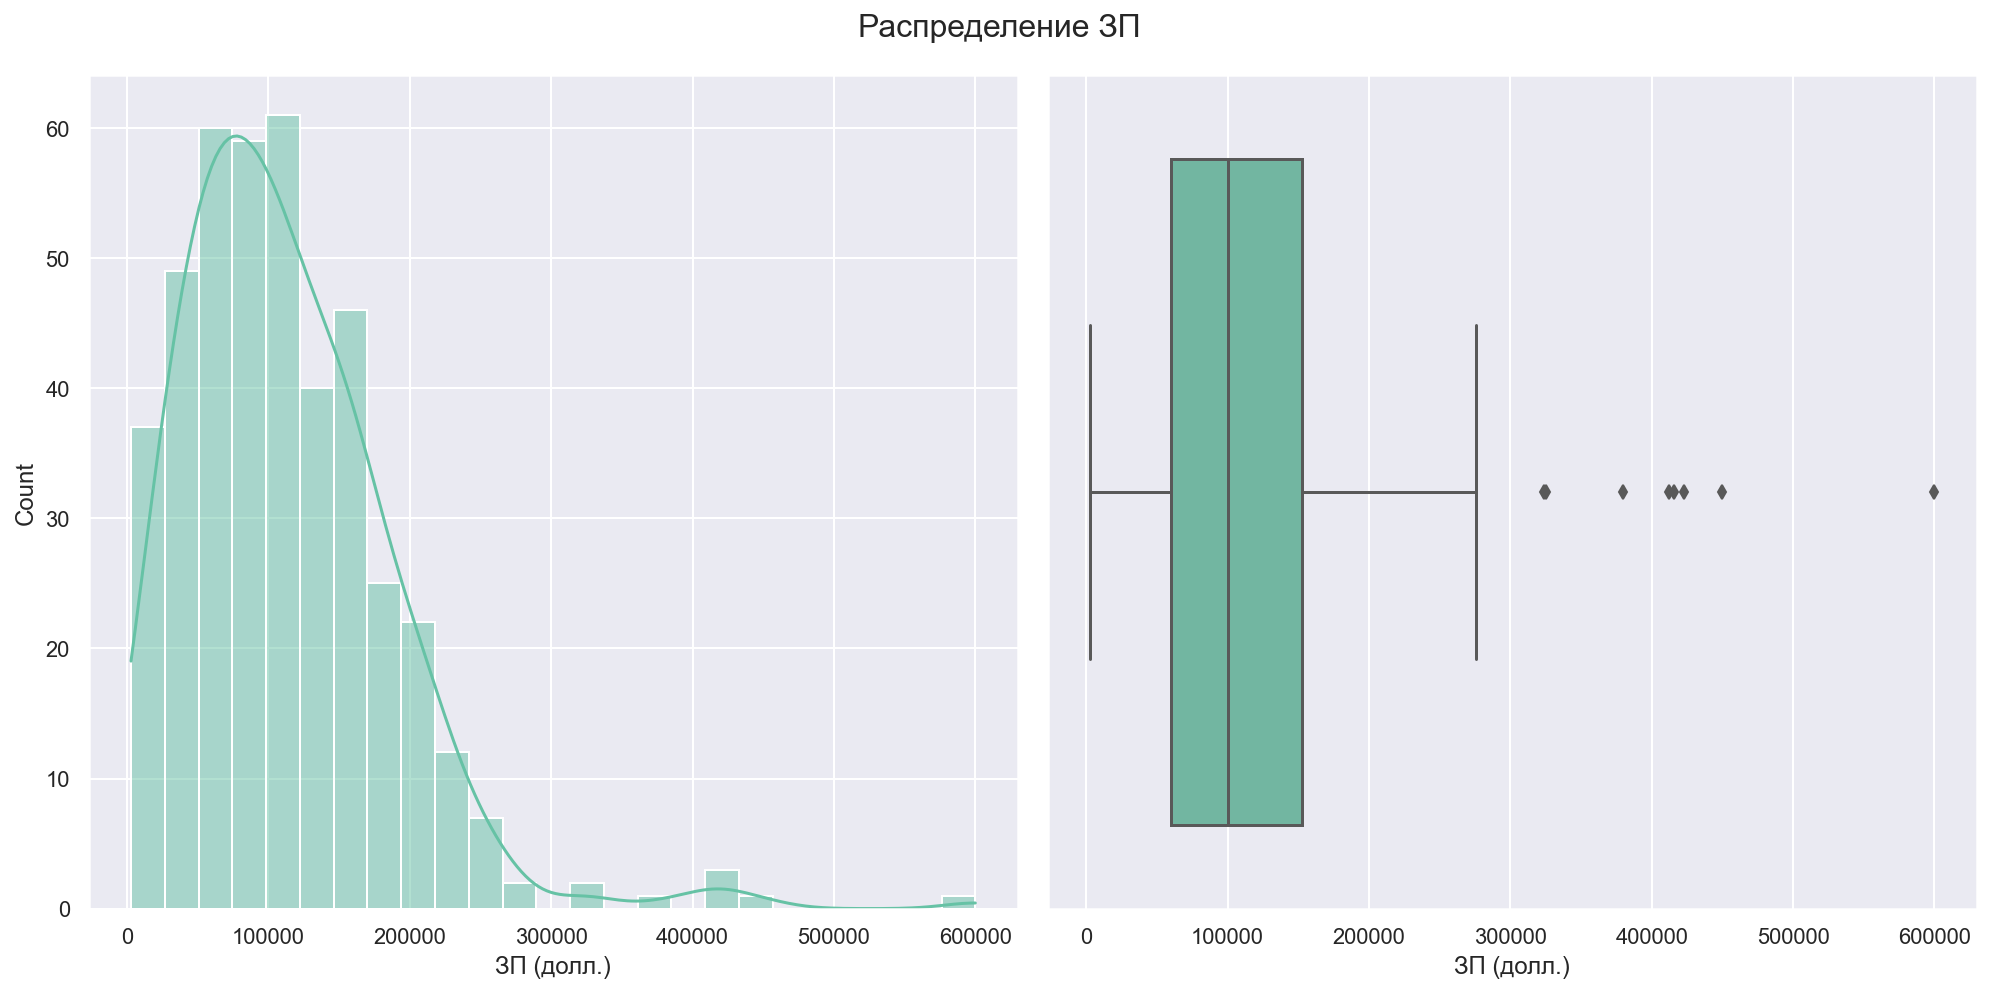

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
sns.histplot(df, x='salary_in_usd', kde=True, ax=ax[0])
ax[0].set_xlabel('ЗП (долл.)', fontsize=12)

sns.boxplot(df, x='salary_in_usd', ax=ax[1])
ax[1].set_xlabel('ЗП (долл.)', fontsize=12)
ax[1].set_ylabel('')


fig.suptitle('Распределение ЗП', fontsize=16)
plt.tight_layout()
plt.show()

- Видно, что распределение зарплат отлично от нормального, ближе к логнормальному.
- Так же по описательным статистикам было видно что средняя и медиана досточно сильно различаются.

### work_year

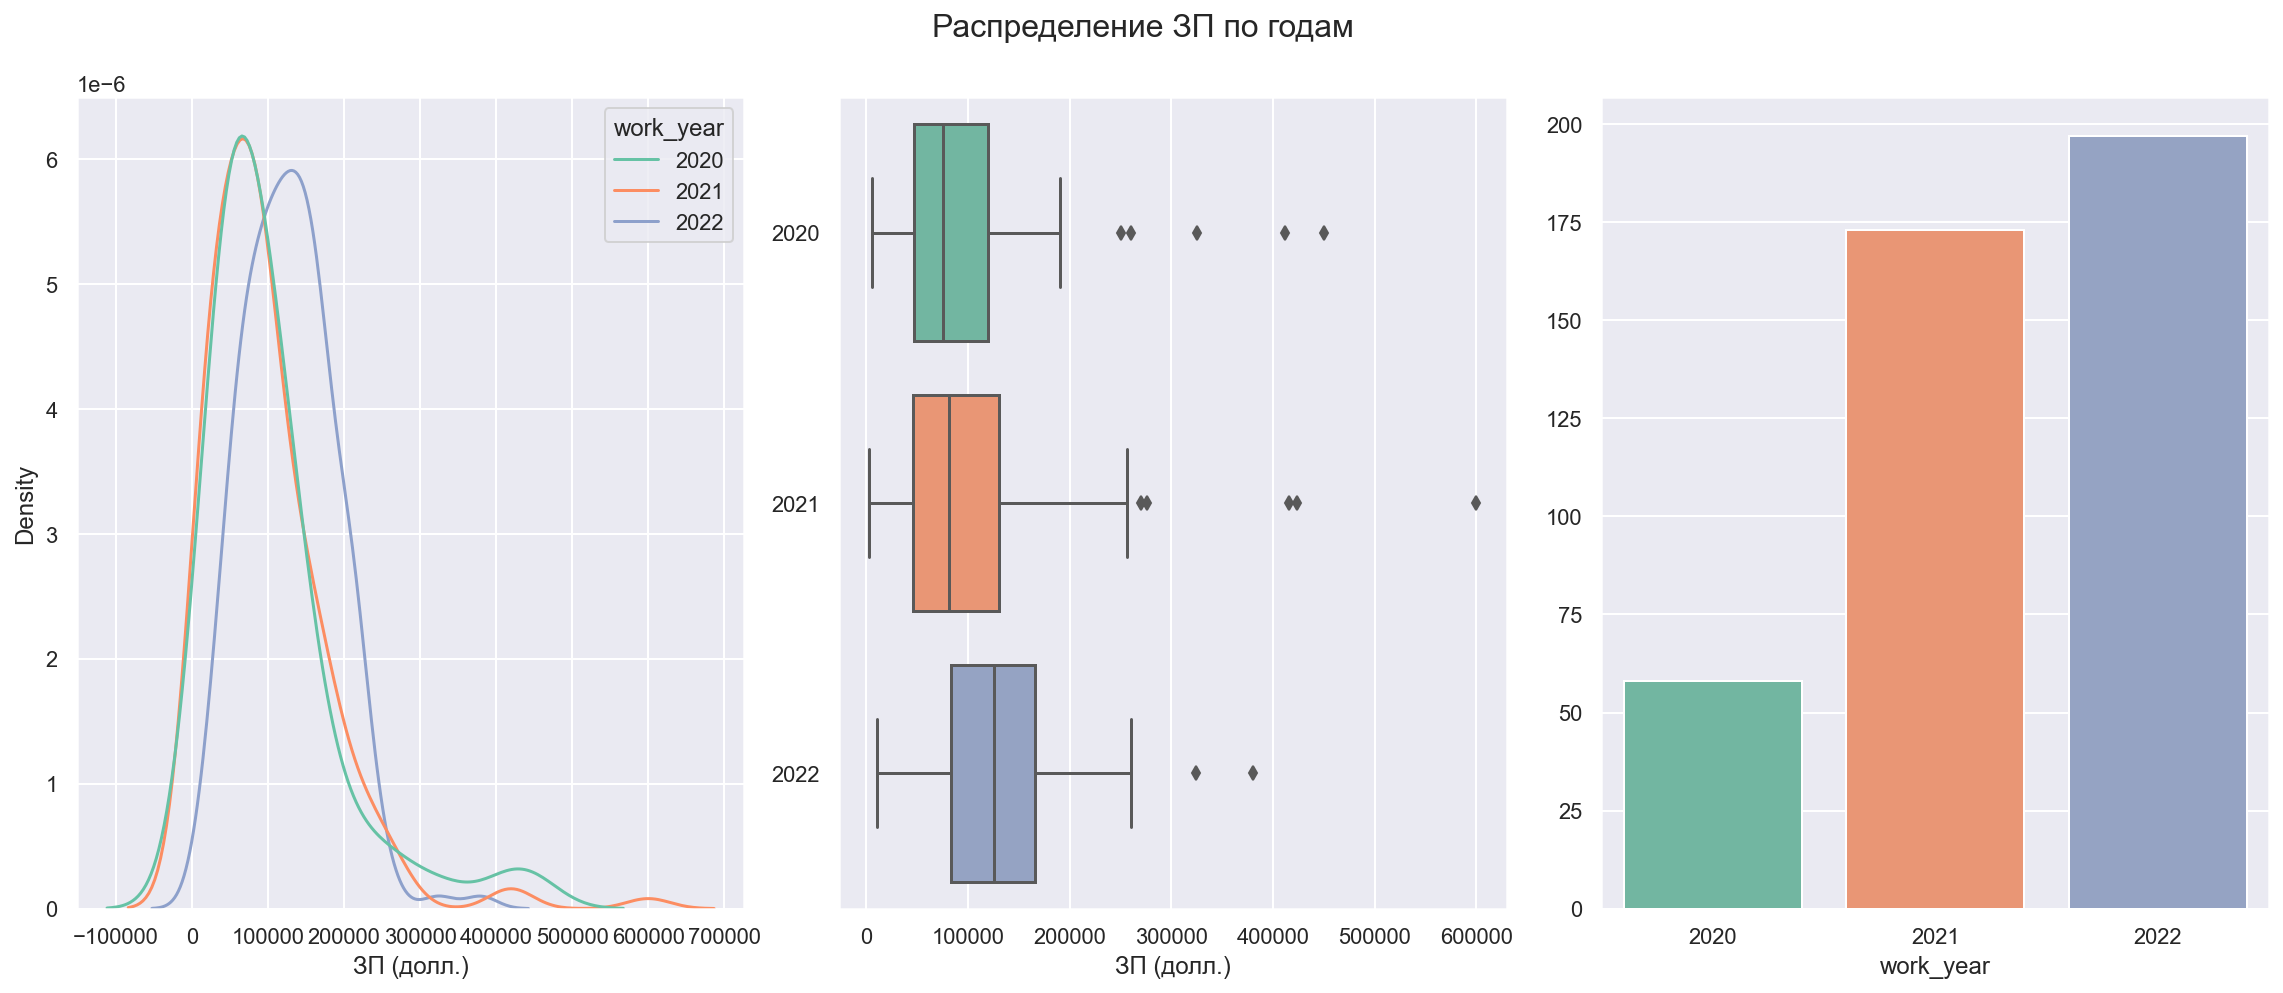

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 7))
sns.kdeplot(df, x='salary_in_usd', hue='work_year', common_norm=False, ax=ax[0])
ax[0].set_xlabel('ЗП (долл.)', fontsize=12)

sns.boxplot(df, x='salary_in_usd', y='work_year', ax=ax[1])
ax[1].set_xlabel('ЗП (долл.)', fontsize=12)
ax[1].set_ylabel('')

sns.countplot(df, x='work_year', ax=ax[2])
ax[2].set_ylabel('')

fig.suptitle('Распределение ЗП по годам', fontsize=16)
plt.tight_layout()
plt.show()

* По кривым плотности видно, что в 21 году ЗП практически не выросла, а вот в 22 году произошел качественных скачок ЗП, все распределение сдвинулось вправо.
* По графику коробки с усами виден рост ЗП и в частности медианной ЗП, особенно качественный рост наблюдается в 22 году.
* Количество работающих в сфере растет год к году

### experience_level

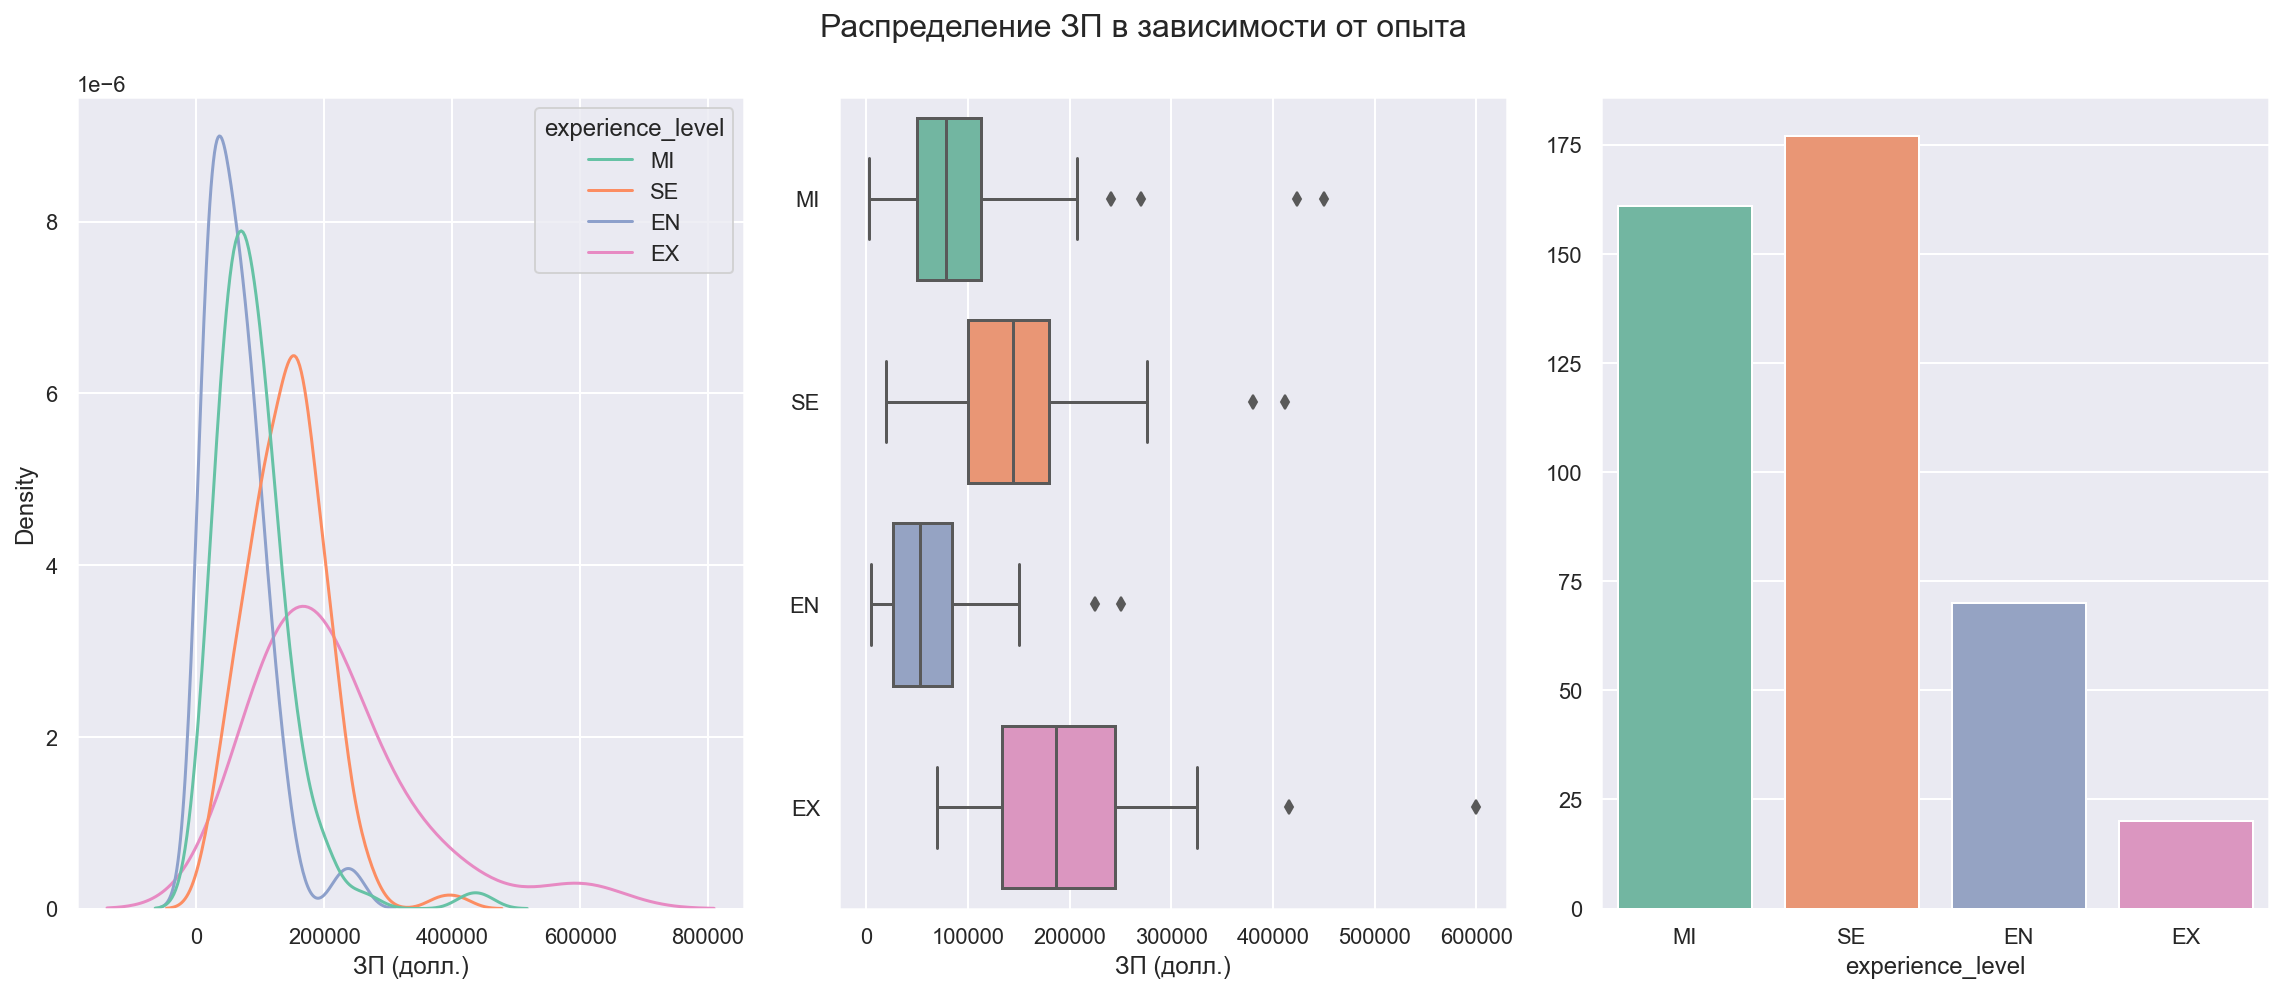

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 7))
sns.kdeplot(df, x='salary_in_usd', hue='experience_level', common_norm=False, ax=ax[0])
ax[0].set_xlabel('ЗП (долл.)', fontsize=12)

sns.boxplot(df, x='salary_in_usd', y='experience_level', ax=ax[1])
ax[1].set_xlabel('ЗП (долл.)', fontsize=12)
ax[1].set_ylabel('')

sns.countplot(df, x='experience_level', ax=ax[2])
ax[2].set_ylabel('')

fig.suptitle('Распределение ЗП в зависимости от опыта', fontsize=16)
plt.tight_layout()
plt.show()

* Видно, что ЗП сильно зависит от опыта.
* Классы опыта более-менее сбалансированны.

### employment_type

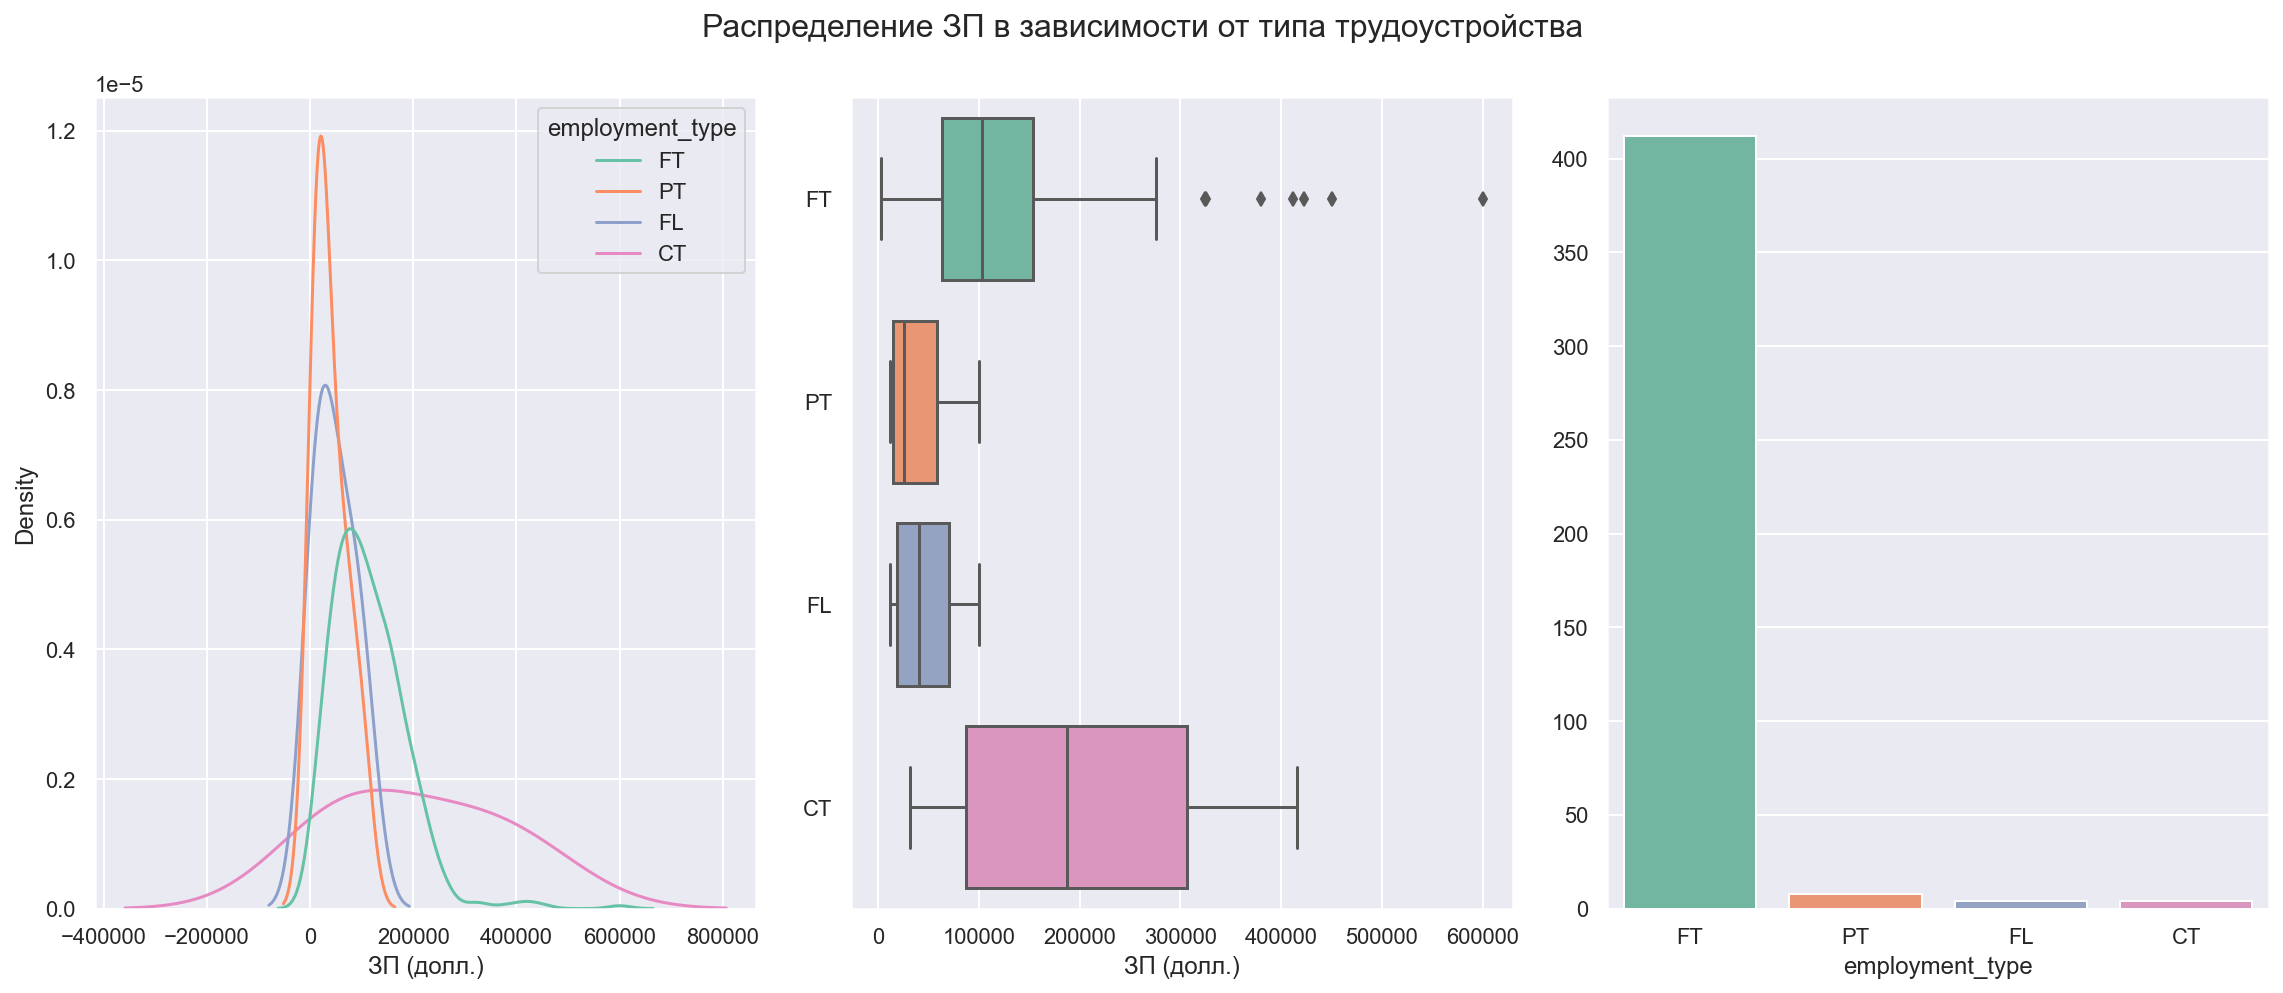

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 7))
sns.kdeplot(df, x='salary_in_usd', hue='employment_type', common_norm=False, ax=ax[0])
ax[0].set_xlabel('ЗП (долл.)', fontsize=12)

sns.boxplot(df, x='salary_in_usd', y='employment_type', ax=ax[1])
ax[1].set_xlabel('ЗП (долл.)', fontsize=12)
ax[1].set_ylabel('')

sns.countplot(df, x='employment_type', ax=ax[2])
ax[2].set_ylabel('')

fig.suptitle('Распределение ЗП в зависимости от типа трудоустройства', fontsize=16)
plt.tight_layout()
plt.show()

* Классы типа трудоустройства сильно несбалансированны, почти все ушло в класс FT. Предполагается что большинство работников работают на одну компанию Full Time, проекты большие и долгосрочные.
* Медианная ЗП для FT и СT находится в одной области и сильно выше чем у PT, FL.
* При этом ЗП контрактника может сильно различаться, кробока самая большая. А на кривой плотности видны самые длинные хвосты.

### remote_ratio

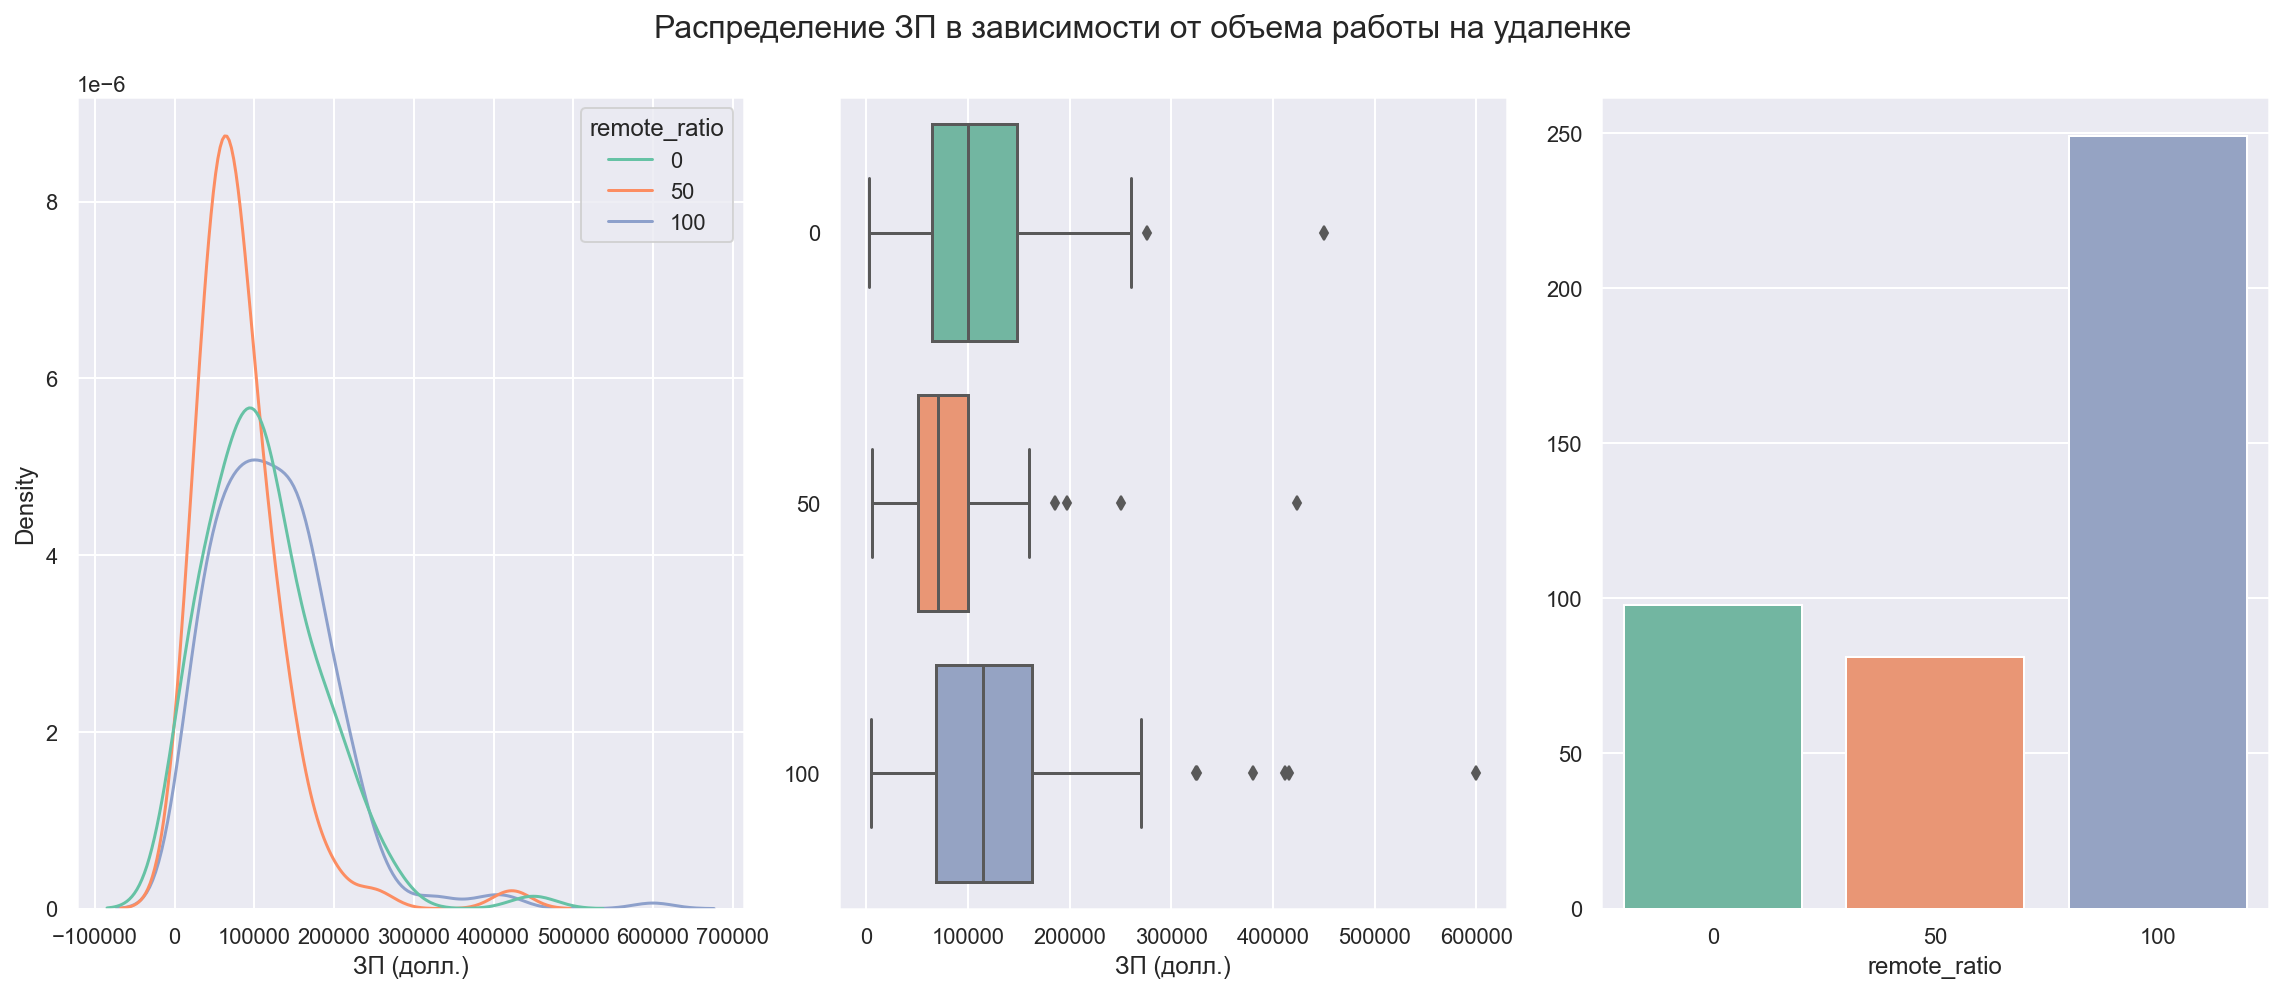

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 7))
sns.kdeplot(df, x='salary_in_usd', hue='remote_ratio', common_norm=False, ax=ax[0])
ax[0].set_xlabel('ЗП (долл.)', fontsize=12)

sns.boxplot(df, x='salary_in_usd', y='remote_ratio', ax=ax[1])
ax[1].set_xlabel('ЗП (долл.)', fontsize=12)
ax[1].set_ylabel('')

sns.countplot(df, x='remote_ratio', ax=ax[2])
ax[2].set_ylabel('')

fig.suptitle('Распределение ЗП в зависимости от объема работы на удаленке', fontsize=16)
plt.tight_layout()
plt.show()

Полные удаленщики и те кто работают в офисе зарабатывают примерно одинаково, а те кто 50на50 значительно меньше. Интересная закономерность.

Инетересно, что большая часть работает на полной удаленке. Меньше всего работников в режиме 50на50.

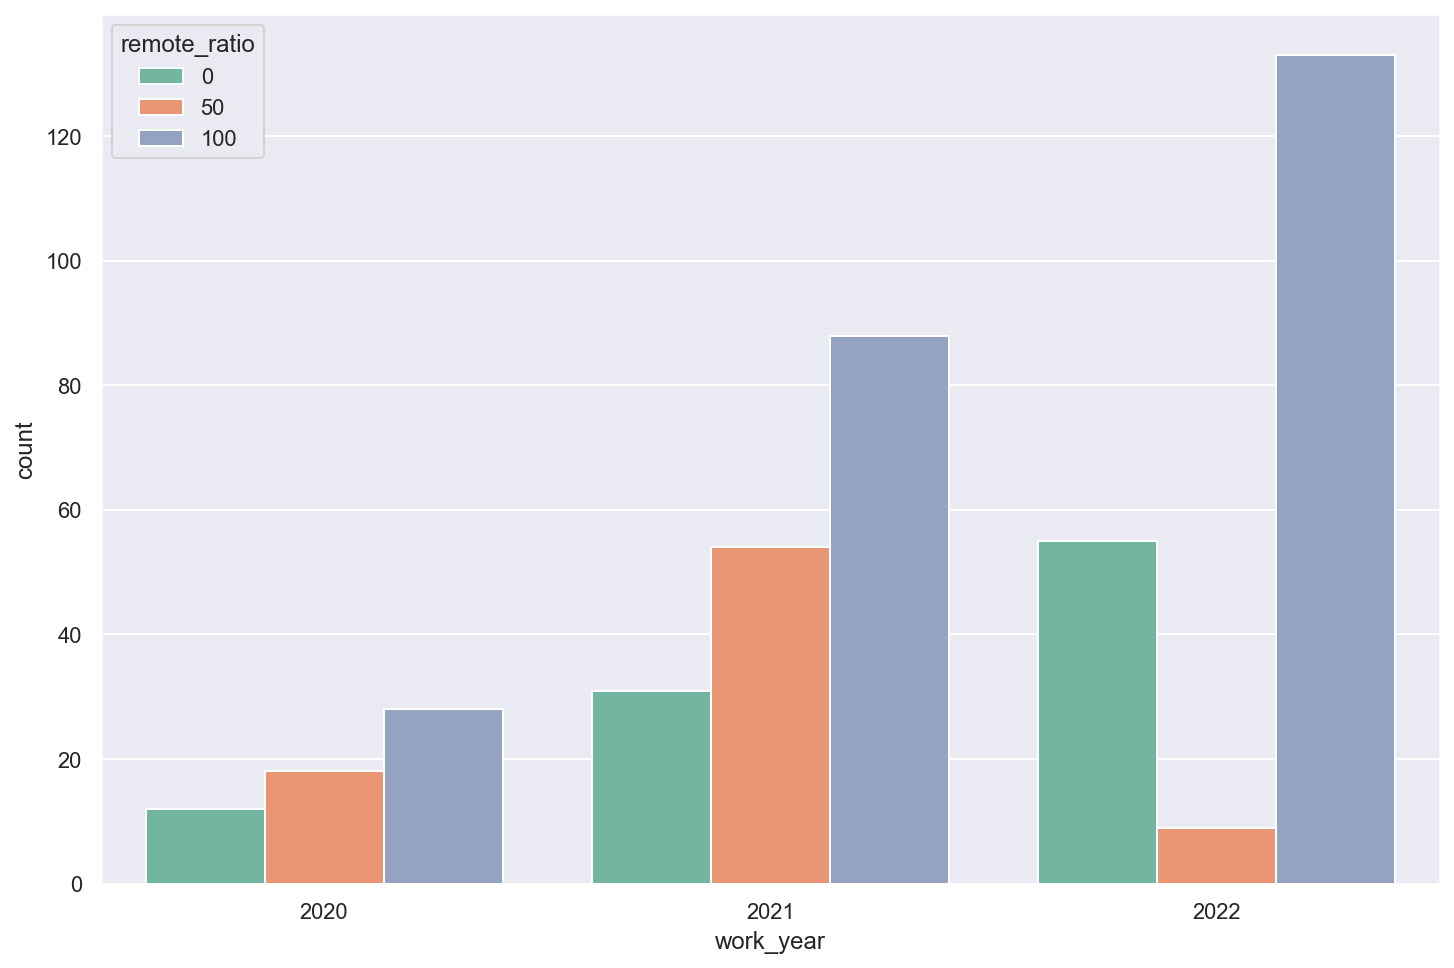

In [29]:
sns.countplot(df, x='work_year', hue='remote_ratio');

* Распределение по годам показывает что полных удаленщиков всегда было больше всего. В последний год класс тех кто работает 50на50 стал самым малочисленным.
* Думаю это связано с ковидным и пост-ковидным периодом за который у нас данные.
    - в 2020 году ковид, всех отправили на удаленку, минимум находится в офисе, чуть больше иногда приездают и самый многочисленный клас - полные удаленщики.
    - в 2021 году тенденция сохранилась, вырос лишь рынок труда и новые работники сразу нанимались на удаленку.
    - в 2022 году компании стали выходить из ковида и возвращать людей в офис, проще всего было вернуть тех, кто и так слонялся туда-сюда. Поэтому по сути сейчас большинство работает либо в офисе, либо полностью на удаленке. 50на50 отмирает и не приветствуется.

### company_size

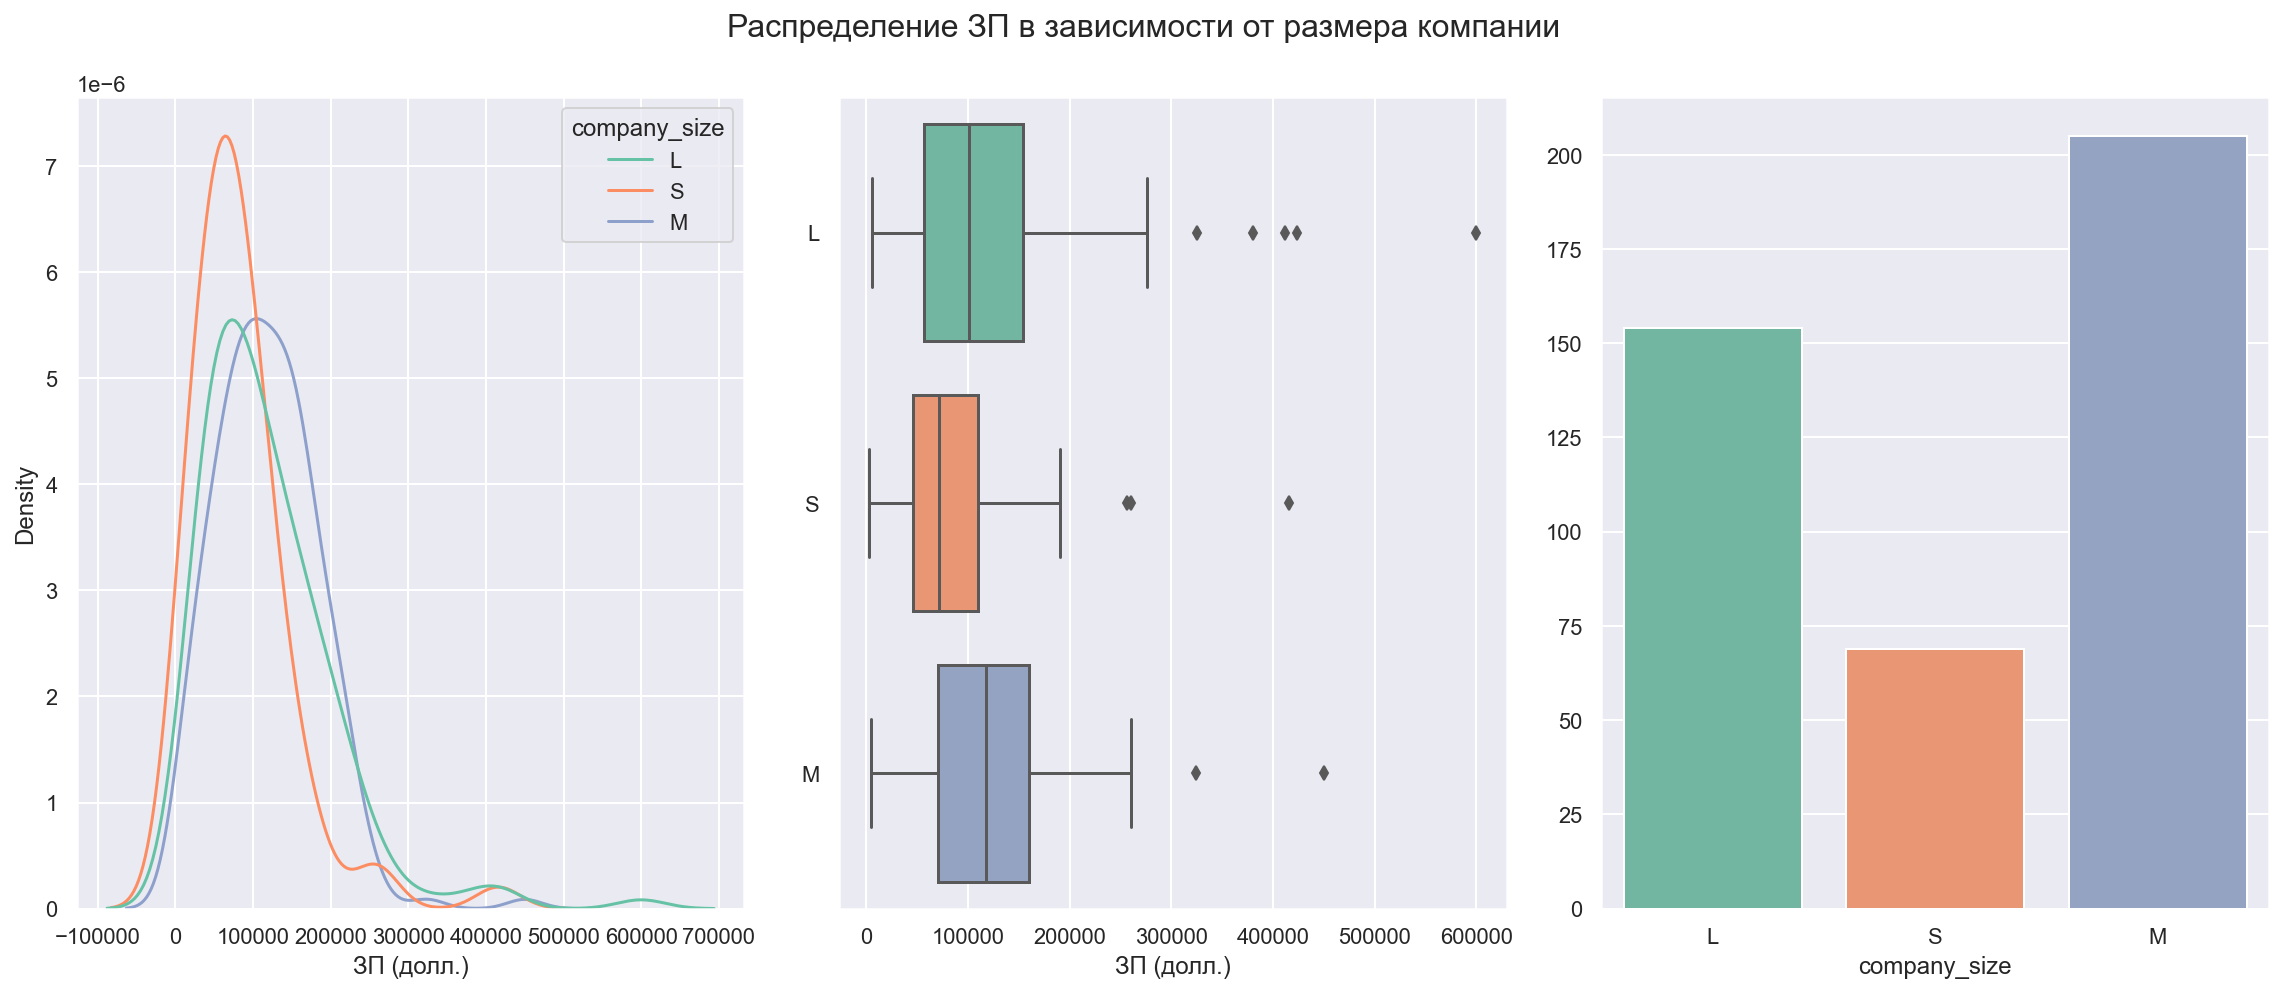

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 7))
sns.kdeplot(df, x='salary_in_usd', hue='company_size', common_norm=False, ax=ax[0])
ax[0].set_xlabel('ЗП (долл.)', fontsize=12)

sns.boxplot(df, x='salary_in_usd', y='company_size', ax=ax[1])
ax[1].set_xlabel('ЗП (долл.)', fontsize=12)
ax[1].set_ylabel('')

sns.countplot(df, x='company_size', ax=ax[2])
ax[2].set_ylabel('')

fig.suptitle('Распределение ЗП в зависимости от размера компании', fontsize=16)
plt.tight_layout()
plt.show()

* Маленькие компании платят меньше всего
* Между средними и большими разница не столь существенна
* Маленькие компании меньше всего нанимают DS спецов, не до этого им

### job_title

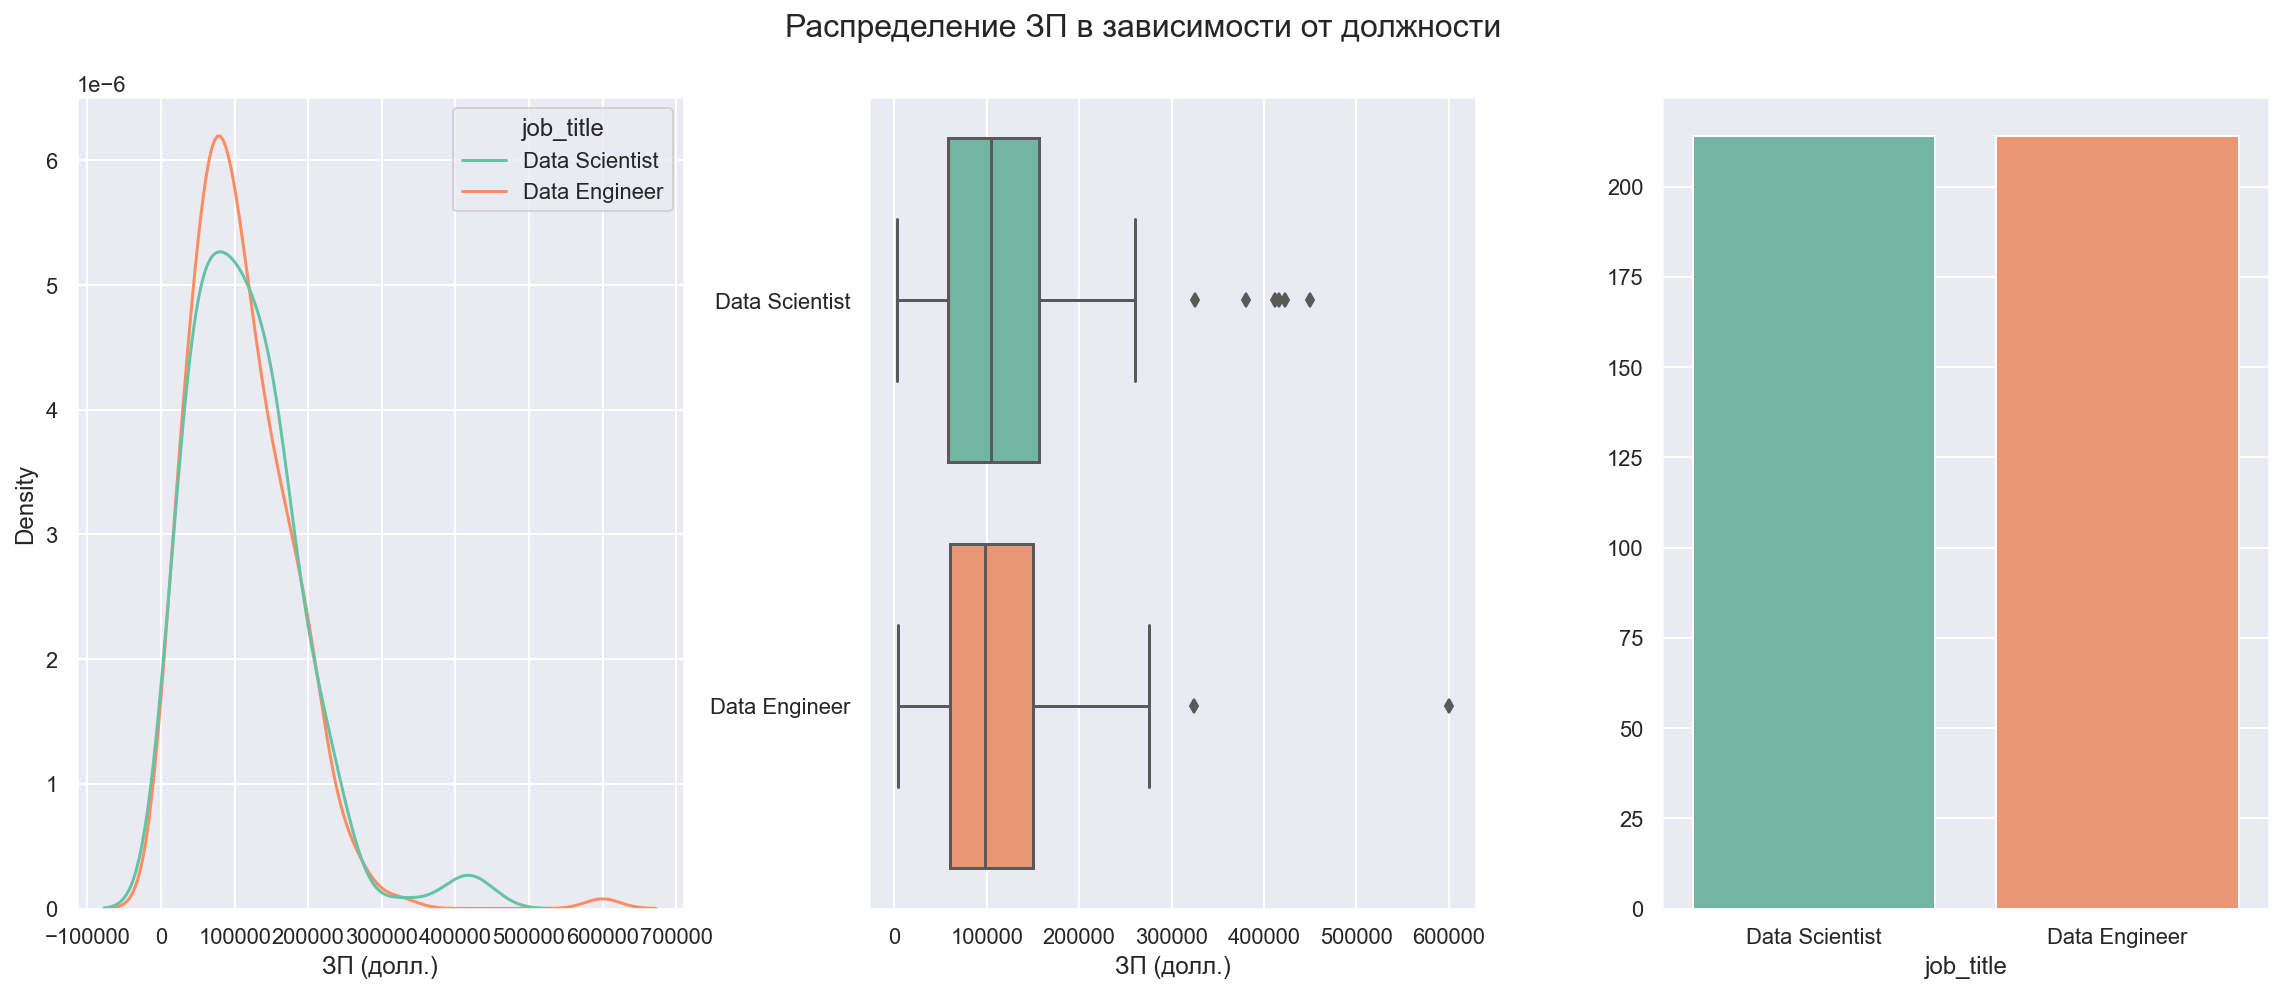

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 7))
sns.kdeplot(df, x='salary_in_usd', hue='job_title', common_norm=False, ax=ax[0])
ax[0].set_xlabel('ЗП (долл.)', fontsize=12)

sns.boxplot(df, x='salary_in_usd', y='job_title', ax=ax[1])
ax[1].set_xlabel('ЗП (долл.)', fontsize=12)
ax[1].set_ylabel('')

sns.countplot(df, x='job_title', ax=ax[2])
ax[2].set_ylabel('')

fig.suptitle('Распределение ЗП в зависимости от должности', fontsize=16)
plt.tight_layout()
plt.show()

ЗП в зависимости от должности практически не отличаются, только хвосты и выбросы немного другие

### salary_currency

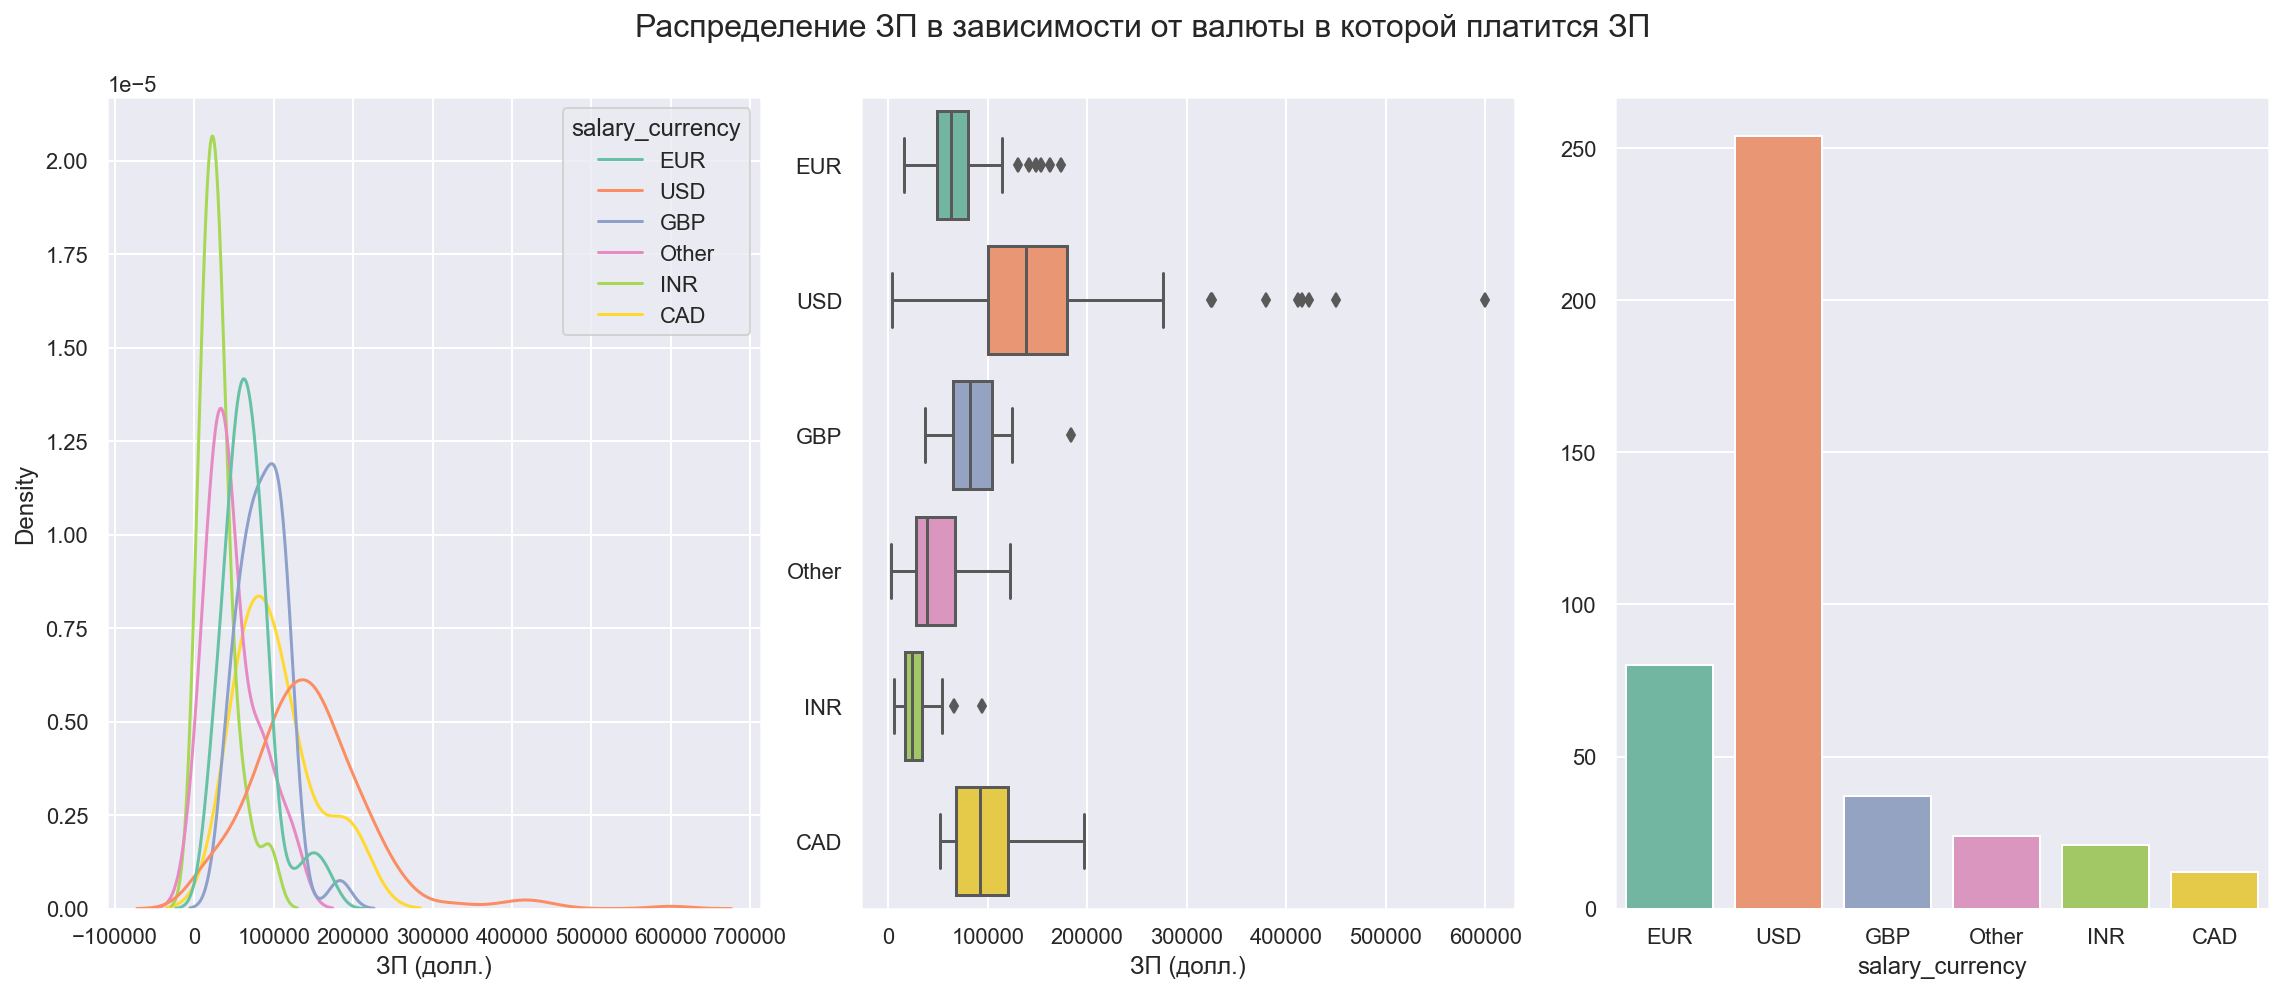

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 7))
sns.kdeplot(df, x='salary_in_usd', hue='salary_currency', common_norm=False, ax=ax[0])
ax[0].set_xlabel('ЗП (долл.)', fontsize=12)

sns.boxplot(df, x='salary_in_usd', y='salary_currency', ax=ax[1])
ax[1].set_xlabel('ЗП (долл.)', fontsize=12)
ax[1].set_ylabel('')

sns.countplot(df, x='salary_currency', ax=ax[2])
ax[2].set_ylabel('')

fig.suptitle('Распределение ЗП в зависимости от валюты в которой платится ЗП', fontsize=16)
plt.tight_layout()
plt.show()

ЗП которая платится в USD сильно выше ЗП в других валютах. Меньше всего платят в индийских рупиях.

### employee_residence

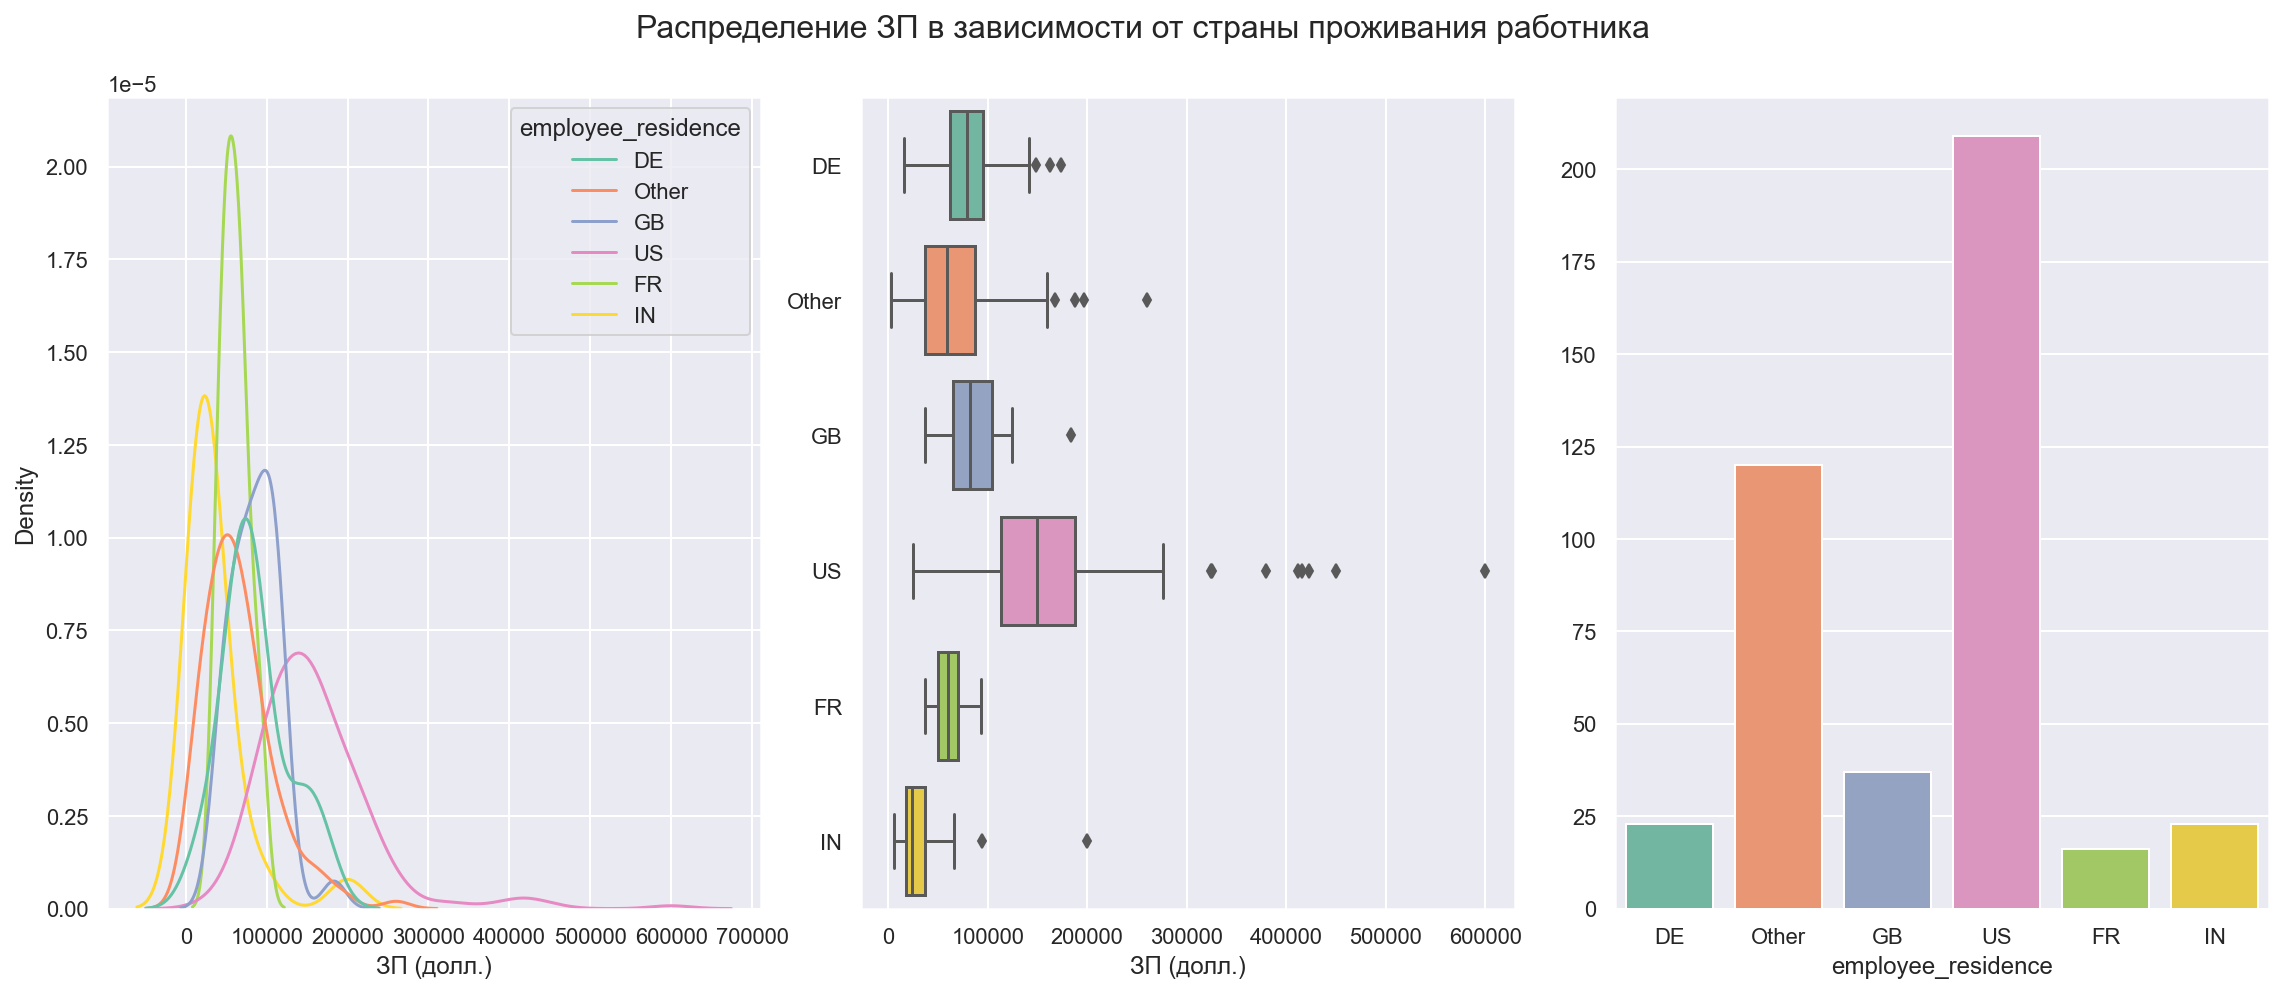

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 7))
sns.kdeplot(df, x='salary_in_usd', hue='employee_residence', common_norm=False, ax=ax[0])
ax[0].set_xlabel('ЗП (долл.)', fontsize=12)

sns.boxplot(df, x='salary_in_usd', y='employee_residence', ax=ax[1])
ax[1].set_xlabel('ЗП (долл.)', fontsize=12)
ax[1].set_ylabel('')

sns.countplot(df, x='employee_residence', ax=ax[2])
ax[2].set_ylabel('')

fig.suptitle('Распределение ЗП в зависимости от страны проживания работника', fontsize=16)
plt.tight_layout()
plt.show()

Американцам платят больше всего, индусам меньше всего.

In [34]:
df.describe(exclude='number').T

,count,unique,top,freq
work_year,428,3,2022,197
experience_level,428,4,SE,177
employment_type,428,4,FT,412
job_title,428,2,Data Scientist,214
salary_currency,428,6,USD,254
employee_residence,428,6,US,209
remote_ratio,428,3,100,249
company_location,428,6,US,228
company_size,428,3,M,205


### company_location

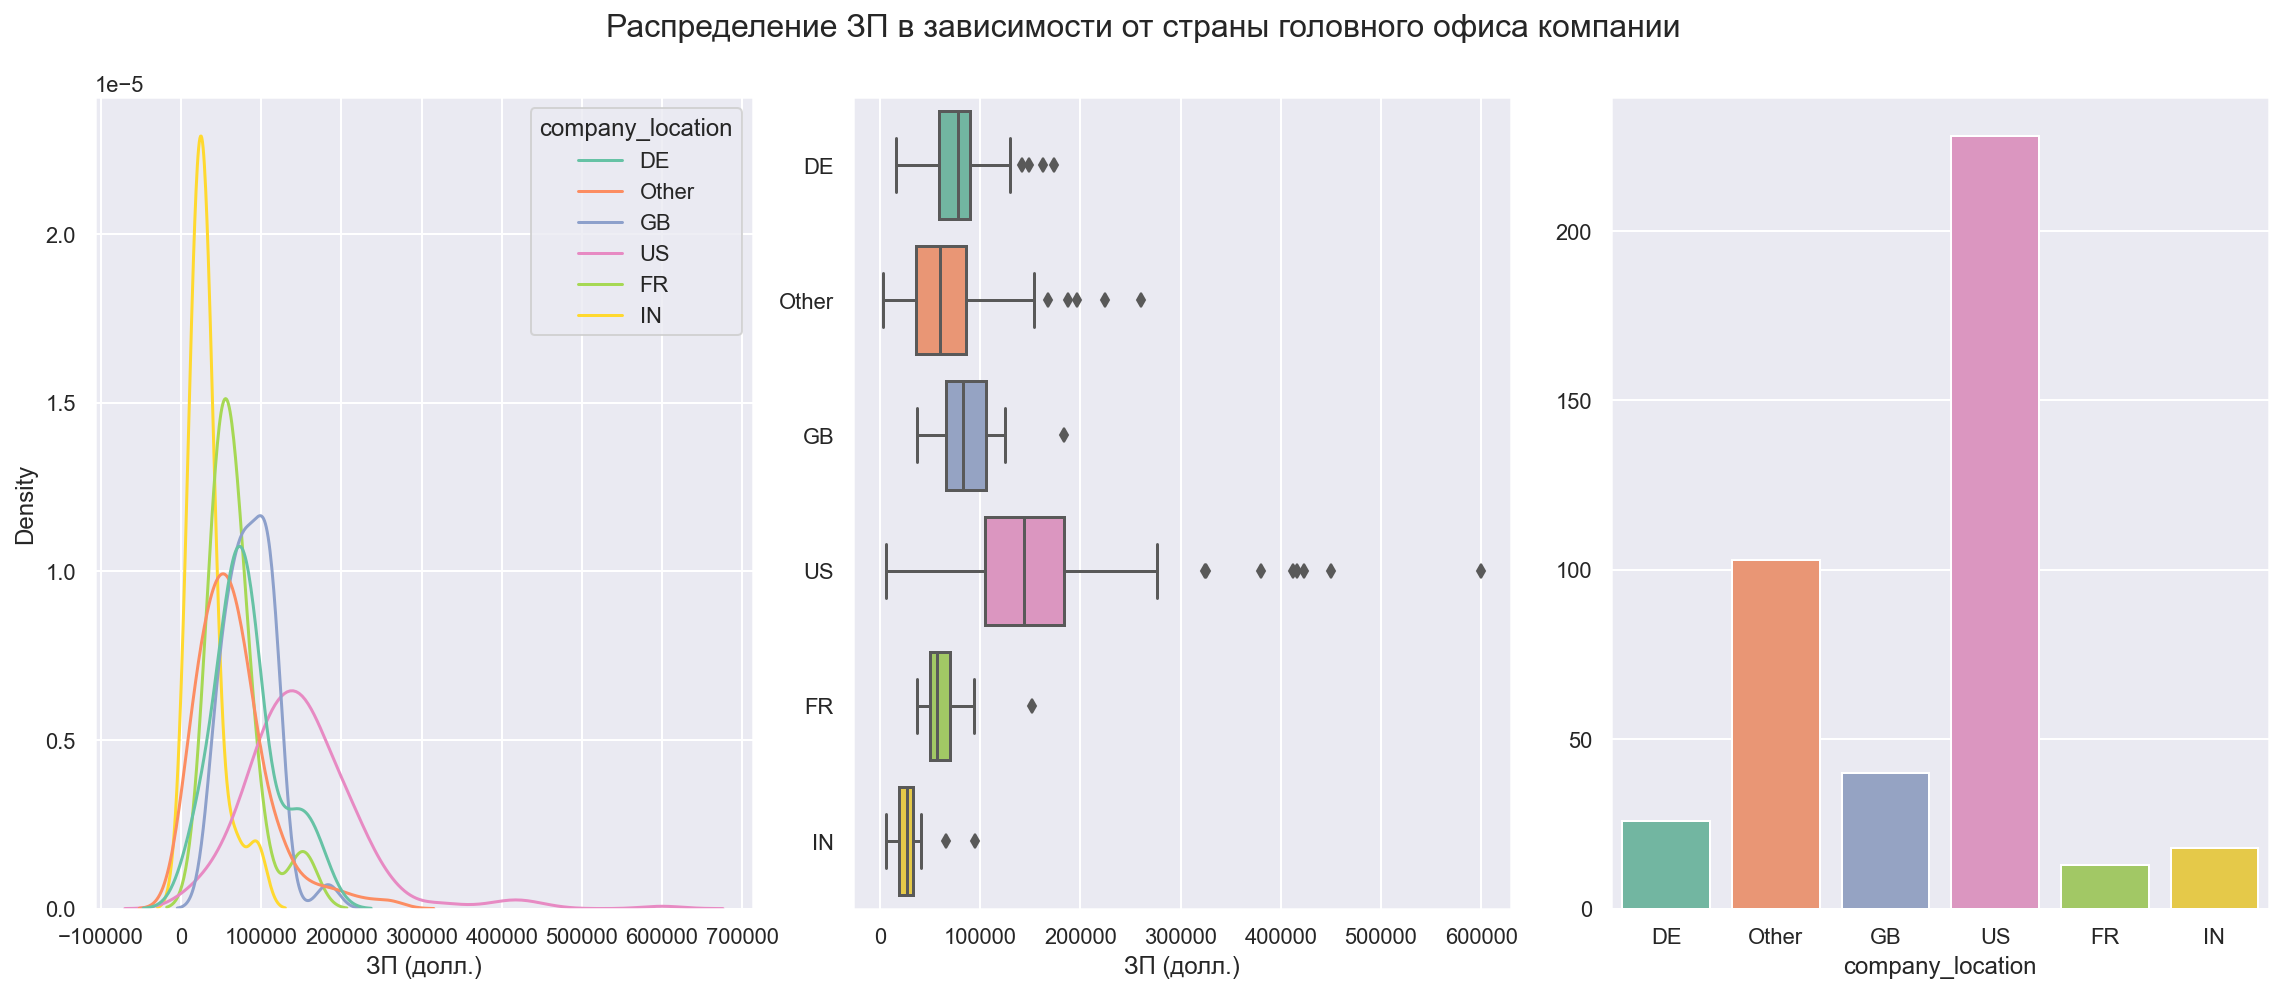

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 7))
sns.kdeplot(df, x='salary_in_usd', hue='company_location', common_norm=False, ax=ax[0])
ax[0].set_xlabel('ЗП (долл.)', fontsize=12)

sns.boxplot(df, x='salary_in_usd', y='company_location', ax=ax[1])
ax[1].set_xlabel('ЗП (долл.)', fontsize=12)
ax[1].set_ylabel('')

sns.countplot(df, x='company_location', ax=ax[2])
ax[2].set_ylabel('')

fig.suptitle('Распределение ЗП в зависимости от страны головного офиса компании', fontsize=16)
plt.tight_layout()
plt.show()

Американские компании платят больше всего, индийские меньше всего.

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 428 entries, 0 to 427
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   work_year           428 non-null    category
 1   experience_level    428 non-null    object  
 2   employment_type     428 non-null    object  
 3   job_title           428 non-null    object  
 4   salary_currency     428 non-null    object  
 5   salary_in_usd       428 non-null    int64   
 6   employee_residence  428 non-null    object  
 7   remote_ratio        428 non-null    category
 8   company_location    428 non-null    object  
 9   company_size        428 non-null    object  
dtypes: category(2), int64(1), object(7)
memory usage: 28.0+ KB


# 2. Статистический анализ данных

In [37]:
# Определяю уровень значимости для будущих тестов
alpha = 0.05

In [38]:
def decision_normality(data, alpha):
    _, p = stats.shapiro(data)
    
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print(f'p-значение меньше, чем заданный уровень значимости {alpha:.2f}.\nРаспределение отлично от нормального.')
    else:
        print(f'p-значение больше, чем заданный уровень значимости {alpha:.2f}.\nРаспределение является нормальным.')
    print()    


def decision_hypothesis(p, alpha, H0='', Ha=''):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print(f'p-значение меньше, чем заданный уровень значимости {alpha:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.\n{Ha}')
    else:
        print(f'p-значение больше, чем заданный уровень значимости {alpha:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.\n{H0}')
    print()

## Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

In [39]:
df[df['job_title'] == 'Data Scientist'].groupby('work_year')['salary_in_usd'].aggregate(['mean', 'median']).round().astype(int)

,mean,median
work_year,,
2020,115014,78396
2021,96855,82500
2022,136964,140000


Медианная ЗП растет год к году, а вот средняя ЗП в 21 году снижалась. Делаю вывод, что ЗП растет год к году.

Необходимо подтвержить это статистическим тестом.

Необходимо сделать выборки ЗП специалистов Data Scientist по годам

In [40]:
salary_ds_in_2020 = df[(df['job_title'] == 'Data Scientist') & (df['work_year'] == 2020)]['salary_in_usd']
salary_ds_in_2021 = df[(df['job_title'] == 'Data Scientist') & (df['work_year'] == 2021)]['salary_in_usd']
salary_ds_in_2022 = df[(df['job_title'] == 'Data Scientist') & (df['work_year'] == 2022)]['salary_in_usd']

Необходимо проверить данные на нормальность. Предварительно было видно, что в целом на всем датасете ЗП далеко от нормального.

In [41]:
# проводим тест Шапиро-Уилка
print('ЗП в 2020 году:')
decision_normality(salary_ds_in_2020, alpha)

print('ЗП в 2021 году:')
decision_normality(salary_ds_in_2021, alpha)

print('ЗП в 2022 году:')
decision_normality(salary_ds_in_2022, alpha)


ЗП в 2020 году:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05.
Распределение отлично от нормального.

ЗП в 2021 году:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05.
Распределение отлично от нормального.

ЗП в 2022 году:
p-value = 0.024
p-значение меньше, чем заданный уровень значимости 0.05.
Распределение отлично от нормального.



По всем годам распределения ЗП отличны от нормального. Необходимо использовать непапраметрические тесты.

Для начала сформулирую вопрос для группы 3+ чуть иначе - отличается ли ЗП год от года.

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака salary_in_usd? — Количественный.
* Сколько сравниваемых групп? — 3.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

Сформулирую нулевую и альтернативную гипотезы:

In [42]:
H0 = 'ЗП во все годы примерно одинаковые.'
Ha = 'ЗП в разные годы отличаются.'

_, p = stats.kruskal(salary_ds_in_2020, salary_ds_in_2021, salary_ds_in_2022)
decision_hypothesis(p, alpha, H0, Ha)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.
ЗП в разные годы отличаются.



Теперь переформулирую исходный вопрос разделив на два вопроса:
1. Наблюдается ли рост ЗП в 2021 году по отношению к 2020.
2. Наблюдается ли рост ЗП в 2022 году по отношению к 2021.

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака salary_in_usd? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Чтобы проверить нашу гипотезу, можно использовать U-критерий Манна — Уитни для сравнения распределений на основе рангов.

Сформулирую нулевую и альтернативную гипотезы:


In [43]:
H0 = 'ЗП в 2021 году уменьшилась, либо осталась такой же как и в 2020.'
Ha = 'ЗП в 2021 году увеличилась по сравнению с 2020 годом.'

_, p = stats.mannwhitneyu(salary_ds_in_2021, salary_ds_in_2020, alternative='greater')
decision_hypothesis(p, alpha, H0, Ha)

p-value = 0.619
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.
ЗП в 2021 году уменьшилась, либо осталась такой же как и в 2020.



In [44]:
H0 = 'ЗП в 2022 году уменьшилась, либо осталась такой же как и в 2021.'
Ha = 'ЗП в 2022 году увеличилась по сравнению с 2021 годом.'

_, p = stats.mannwhitneyu(salary_ds_in_2022, salary_ds_in_2021, alternative='greater')
decision_hypothesis(p, alpha, H0, Ha)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.
ЗП в 2022 году увеличилась по сравнению с 2021 годом.



## Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?

In [45]:
df[df['work_year'] == 2022].groupby('job_title')['salary_in_usd'].aggregate(['mean', 'median']).round().astype(int)

,mean,median
job_title,,
Data Engineer,121774,117988
Data Scientist,136964,140000


Делаю вывод что в 2022 году ЗП у DS выше чем у DE.

Необходимо подтверждение вывоза статистическим тестом.

Необходимо сделать выборки ЗП по году и должностям

In [46]:
salary_de_in_2022 = df[(df['job_title'] == 'Data Engineer') & (df['work_year'] == 2022)]['salary_in_usd']
salary_ds_in_2022 = df[(df['job_title'] == 'Data Scientist') & (df['work_year'] == 2022)]['salary_in_usd']

Необходимо проверить данные на нормальность. Предварительно было видно, что в целом на всем датасете ЗП далеко от нормального.

In [47]:
# проводим тест Шапиро-Уилка
print('ЗП в 2022 году у DE:')
decision_normality(salary_de_in_2022, alpha)

print('ЗП в 2022 году у DS:')
decision_normality(salary_ds_in_2022, alpha)

ЗП в 2022 году у DE:
p-value = 0.032
p-значение меньше, чем заданный уровень значимости 0.05.
Распределение отлично от нормального.

ЗП в 2022 году у DS:
p-value = 0.024
p-значение меньше, чем заданный уровень значимости 0.05.
Распределение отлично от нормального.



**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака salary_in_usd? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Чтобы проверить нашу гипотезу, можно использовать U-критерий Манна — Уитни для сравнения распределений на основе рангов.

Сформулирую нулевую и альтернативную гипотезы:

In [48]:
H0 = 'В 2022 году ЗП у DS меньше, либо равна DE.'
Ha = 'В 2022 году ЗП у DS выше чем у DE.'

_, p = stats.mannwhitneyu(salary_ds_in_2022, salary_de_in_2022, alternative='greater')
decision_hypothesis(p, alpha, H0, Ha)

p-value = 0.029
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.
В 2022 году ЗП у DS выше чем у DE.



## Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?

In [49]:
df[df['job_title'] == 'Data Scientist'].groupby('company_size')['salary_in_usd'].aggregate(['mean', 'median']).round().astype(int)

,mean,median
company_size,,
L,124447,111168
M,122557,120160
S,79249,62726


- Маленькие компании платят меньше чем средние.
- Средние и большие компании платят примерно одинаково.

Необходимы статистические тесты для подтверждения выводов.

Необходимо сделать выборки ЗП по году и должностям

In [50]:
salary_ds_in_S_company = df[(df['job_title'] == 'Data Scientist') & (df['company_size'] == 'S')]['salary_in_usd']
salary_ds_in_M_company = df[(df['job_title'] == 'Data Scientist') & (df['company_size'] == 'M')]['salary_in_usd']
salary_ds_in_L_company = df[(df['job_title'] == 'Data Scientist') & (df['company_size'] == 'L')]['salary_in_usd']

Необходимо проверить данные на нормальность. Предварительно было видно, что в целом на всем датасете ЗП далеко от нормального.

In [51]:
# проводим тест Шапиро-Уилка
print('ЗП DS в маленьких компаниях:')
decision_normality(salary_ds_in_S_company, alpha)

print('ЗП DS в средних компаниях:')
decision_normality(salary_ds_in_M_company, alpha)

print('ЗП DS в больших компаниях:')
decision_normality(salary_ds_in_L_company, alpha)

ЗП DS в маленьких компаниях:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05.
Распределение отлично от нормального.

ЗП DS в средних компаниях:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05.
Распределение отлично от нормального.

ЗП DS в больших компаниях:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05.
Распределение отлично от нормального.



### Проверяю первый тезис - Маленькие компании платят меньше чем средние.

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака salary_in_usd? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Чтобы проверить нашу гипотезу, можно использовать U-критерий Манна — Уитни для сравнения распределений на основе рангов.

Сформулирую нулевую и альтернативную гипотезы:

In [52]:
H0 = 'Маленькие компании платят DS сотрудникам больше чем средние или столько же.'
Ha = 'Маленькие компании платят DS сотрудникам меньше чем средние.'

_, p = stats.mannwhitneyu(salary_ds_in_S_company, salary_ds_in_M_company, alternative='less')
decision_hypothesis(p, alpha, H0, Ha)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.
Маленькие компании платят DS сотрудникам меньше чем средние.



### Проверяю второй тезис - Средние и большие компании платят примерно одинаково.

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака salary_in_usd? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Чтобы проверить нашу гипотезу, можно использовать U-критерий Манна — Уитни для сравнения распределений на основе рангов.

Сформулирую нулевую и альтернативную гипотезы:

In [53]:
H0 = 'ЗП сотрудников DS в средних и больших компаниях отличаются.'
Ha = 'Средние и большие компании платят сотрудникам DS в среднем одинаковые зарплаты.'

_, p = stats.mannwhitneyu(salary_ds_in_M_company, salary_ds_in_L_company, alternative='two-sided')
decision_hypothesis(p, alpha, H0, Ha)

p-value = 0.594
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.
ЗП сотрудников DS в средних и больших компаниях отличаются.



## Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

Сформулирую нулевую и альтернативную гипотезы:

In [54]:
H0 = 'Между наличием должностей DS и DE и размером компании нет взаимосвязи (признаки независимы).'
Ha = 'Между наличием должностей DS и DE и размером компании есть взаимосвязь (признаки зависимы).'

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака job_title? — Категориальный.
* Сколько сравниваемых групп? — Две.
* Проверяется независимость групп? — Да.

Для проверки нашей гипотезы можно использовать критерий ${\chi}^2$ (хи-квадрат).

**Проведём тест**

In [55]:
cross_table = pd.crosstab(df['job_title'], df['company_size'])
cross_table

company_size,L,M,S
job_title,,,
Data Engineer,66,114,34
Data Scientist,88,91,35


In [56]:
# проводим тест
_, p, _, _ = stats.chi2_contingency(cross_table)
decision_hypothesis(p, alpha, H0, Ha)

p-value = 0.057
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.
Между наличием должностей DS и DE и размером компании нет взаимосвязи (признаки независимы).



# 3. Дополнительное исследование 

## ЗП для DS и DE за все годы больше 100000 долл.?

In [57]:
df['salary_in_usd'].aggregate(['mean', 'median']).to_frame().round()

,salary_in_usd
mean,112608.0
median,100000.0


ЗП больше 100т.

Провожу проверку статистическим тестом.

In [58]:
level = 100000
all_salaries = df['salary_in_usd']

Необходимо проверить данные на нормальность. Предварительно было видно, что в целом на всем датасете ЗП далеко от нормального.

In [59]:
# проводим тест Шапиро-Уилка
print('ЗП для всех работников на всей выборке:')
decision_normality(all_salaries, alpha)

ЗП для всех работников на всей выборке:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05.
Распределение отлично от нормального.



**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака salary_in_usd? — Количественный.
* Сколько сравниваемых групп? — Одна.
* Признак распределён по нормальному закону? — Нет.

Чтобы проверить нашу гипотезу, можно использовать Критерий знаков (для одной выборки).

Сформулирую нулевую и альтернативную гипотезы:

In [60]:
H0 = 'ЗП не равна 100т.'
Ha = 'ЗП равна 100т.'
_, p = sign_test(all_salaries, level)
decision_hypothesis(p, alpha, H0, Ha)

p-value = 0.807
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.
ЗП не равна 100т.

